In [86]:
from itertools import product
import operator        
import datetime
import warnings
warnings.filterwarnings('ignore')

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import pandas as pd

import seaborn as sns
import pandas_profiling as pdf

import sklearn
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler, RobustScaler, PowerTransformer, QuantileTransformer
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, lars_path, ElasticNet, ElasticNetCV, Ridge, RidgeCV
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

# pointer to scaler I want to use
use_transform = RobustScaler

def mytransform():
    return QuantileTransformer(output_distribution='normal')

import scipy.stats as stats
from scipy.stats import skew  
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

#!conda install -y -conda-forge  xgboost 
from xgboost import XGBRegressor
from xgboost import plot_importance

#!conda install -y -c conda-forge lightgbm
from lightgbm import LGBMRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

#!conda install -y -c districtdatalabs yellowbrick
from yellowbrick.features import JointPlotVisualizer, ParallelCoordinates
from yellowbrick.regressor import AlphaSelection, PredictionError, ResidualsPlot

#!conda install -y -c conda-forge mlxtend
from mlxtend.regressor import StackingCVRegressor

import tensorflow.keras as keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, Activation
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

import ipywidgets as widgets
from IPython.display import clear_output
pd.options.display.max_columns=None
#pd.options.display.max_rows=None

numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

print(datetime.datetime.now())



2019-05-22 23:18:22.361717


### 1. Import

In [2]:
# import train data
datadir = "https://raw.githubusercontent.com/druce/iowa/master/data/"
datafile = datadir + "train.csv"
df_raw = pd.read_csv(datafile)
print(df_raw.shape)
display(df_raw.head())

(1460, 81)


Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
0         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
1         Lvl    AllPub       FR2       Gtl      Veenker      Feedr   
2         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
3         Lvl    AllPub    Corner       Gtl      Crawfor       Norm   
4         Lvl    AllPub       FR2       Gtl      NoRidge       Norm   

  Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
0       Norm     1Fam     2Story            7            5       2003   
1       Norm     1Fam     1Story            6            8       1976   
2       Norm     1Fam     2Story            7            5       2001   
3       Norm     1Fam     2Story            7            5       1915   
4       Norm     1Fam     2Story            8            5       2000   

   YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
0          2003     Gable  CompShg     VinylSd     VinylSd    BrkFace   
1          1976     Gable  CompShg     MetalSd     MetalSd       None   
2          2002     Gable  CompShg     VinylSd     VinylSd    BrkFace   
3          1970     Gable  CompShg     Wd Sdng     Wd Shng       None   
4          2000     Gable  CompShg     VinylSd     VinylSd    BrkFace   

   MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond BsmtExposure  \
0       196.0        Gd        TA      PConc       Gd       TA           No   
1         0.0        TA        TA     CBlock       Gd       TA           Gd   
2       162.0        Gd        TA      PConc       Gd       TA           Mn   
3         0.0        TA        TA     BrkTil       TA       Gd           No   
4       350.0        Gd        TA      PConc       Gd       TA           Av   

  BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  \
0          GLQ         706          Unf           0        150          856   
1          ALQ         978          Unf           0        284         1262   
2          GLQ         486          Unf           0        434          920   
3          ALQ         216          Unf           0        540          756   
4          GLQ         655          Unf           0        490         1145   

  Heating HeatingQC CentralAir Electrical  1stFlrSF  2ndFlrSF  LowQualFinSF  \
0    GasA        Ex          Y      SBrkr       856       854             0   
1    GasA        Ex          Y      SBrkr      1262         0             0   
2    GasA        Ex          Y      SBrkr       920       866             0   
3    GasA        Gd          Y      SBrkr       961       756             0   
4    GasA        Ex          Y      SBrkr      1145      1053             0   

   GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  \
0       1710             1             0         2         1             3   
1       1262             0             1         2         0             3   
2       1786             1             0         2         1             3   
3       1717             1             0         1         0             3   
4       2198             1             0         2         1             4   

   KitchenAbvGr KitchenQual  TotRmsAbvGrd Functional  Fireplaces FireplaceQu  \
0             1          Gd             8        Typ           0         NaN   
1             1          TA             6        Typ           1          TA   
2             1          Gd             6        Typ           1          TA   
3             1          Gd            

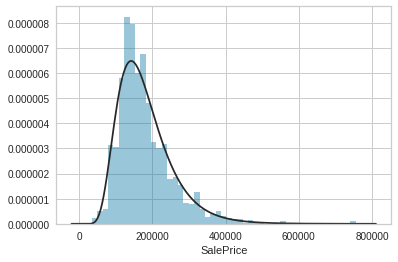

In [3]:
# plot
sns.distplot(df_raw['SalePrice'], kde=False, fit=stats.lognorm);


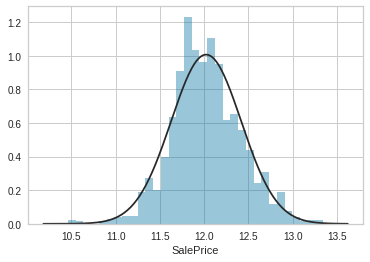

In [4]:
sns.distplot(np.log1p(df_raw.loc[df_raw['GrLivArea']<4000]['SalePrice']), kde=False, fit=stats.norm);


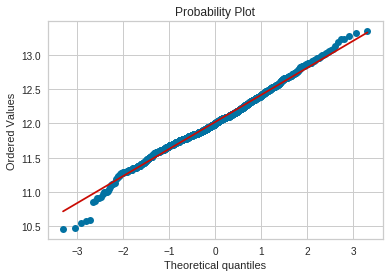

In [5]:
res = stats.probplot(np.log1p(df_raw.loc[df_raw['GrLivArea']<4000]['SalePrice']), plot=plt);

In [6]:
widget_cats = []
widget_nums = []

for col in df_raw.columns:
    if col == 'SalePrice':
        continue
    if df_raw[col].dtype == np.dtype('O'):
        widget_cats.append(col)
    elif len(df_raw[col].value_counts()) <= 25:
        widget_cats.append(col)
    else:
        widget_nums.append(col)
        
widget_cats.sort()        
print(widget_cats)
print()
widget_nums.sort()
print(widget_nums)

['3SsnPorch', 'Alley', 'BedroomAbvGr', 'BldgType', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'BsmtFullBath', 'BsmtHalfBath', 'BsmtQual', 'CentralAir', 'Condition1', 'Condition2', 'Electrical', 'ExterCond', 'ExterQual', 'Exterior1st', 'Exterior2nd', 'Fence', 'FireplaceQu', 'Fireplaces', 'Foundation', 'FullBath', 'Functional', 'GarageCars', 'GarageCond', 'GarageFinish', 'GarageQual', 'GarageType', 'HalfBath', 'Heating', 'HeatingQC', 'HouseStyle', 'KitchenAbvGr', 'KitchenQual', 'LandContour', 'LandSlope', 'LotConfig', 'LotShape', 'LowQualFinSF', 'MSSubClass', 'MSZoning', 'MasVnrType', 'MiscFeature', 'MiscVal', 'MoSold', 'Neighborhood', 'OverallCond', 'OverallQual', 'PavedDrive', 'PoolArea', 'PoolQC', 'RoofMatl', 'RoofStyle', 'SaleCondition', 'SaleType', 'Street', 'TotRmsAbvGrd', 'Utilities', 'YrSold']

['1stFlrSF', '2ndFlrSF', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'EnclosedPorch', 'GarageArea', 'GarageYrBlt', 'GrLivArea', 'Id', 'LotArea', 'LotFrontage', 'MasVnrArea', 

Dropdown(description='Variable:', options=('1stFlrSF', '2ndFlrSF', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'E…

Dropdown(description='Color by:', index=47, options=('3SsnPorch', 'Alley', 'BedroomAbvGr', 'BldgType', 'BsmtCo…

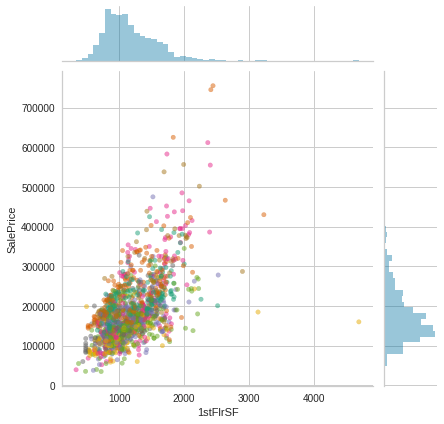

In [7]:
# interactive widget for continuous variables
df = df_raw
def on_value_change1(change):
    do_refresh(change['new'], gColor)

def on_value_change2(change):
    do_refresh(gVar, change['new'])

def do_refresh(var=widget_nums[0], colorby="Neighborhood"):

    global gVar
    gVar = var
    global gColor
    gColor = colorby
    
    clear_output()
    dropdown1 = widgets.Dropdown(
        options=widget_nums,
        value=var,
        description='Variable:',
        disabled=False,)
    display(dropdown1)

    dropdown1.observe(on_value_change1, names='value')

    dropdown2 = widgets.Dropdown(
        options=widget_cats,
        value=colorby,
        description='Color by:',
        disabled=False,)
    display(dropdown2)
    dropdown2.observe(on_value_change2, names='value')
    
    response = 'SalePrice'
    z = df.loc[~df["SalePrice"].isna()]

    norm = matplotlib.colors.Normalize(vmin=0, vmax=21, clip=True)
    mapper = plt.cm.ScalarMappable(norm=norm, cmap=plt.cm.Dark2)
    
    colordict = {k: i for i, k in enumerate(z[colorby].unique())}
    
    sns.jointplot(var, 
                  response, 
                  data=z, 
                  alpha=0.5, 
                  s=20, 
                  joint_kws={"color": z[colorby].apply(lambda x: matplotlib.colors.to_hex(mapper.to_rgba(colordict[x])))}
                 )

do_refresh()
    


Dropdown(description='Cat:', options=('3SsnPorch', 'Alley', 'BedroomAbvGr', 'BldgType', 'BsmtCond', 'BsmtExpos…

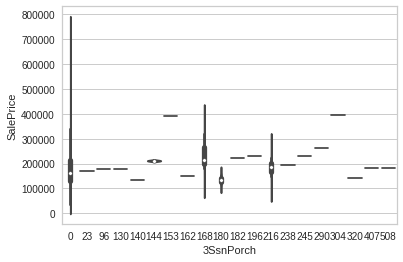

In [8]:
# interactive widget for categorical variables

def on_value_change3(change):
    do_refresh3(change['new'])

def do_refresh3(var=widget_cats[0]):

    clear_output()
    dropdown3 = widgets.Dropdown(
        options=widget_cats,
        value=var,
        description='Cat:',
        disabled=False,)
    display(dropdown3)
    dropdown3.observe(on_value_change3, names='value')
    
    response = 'SalePrice'
    z = df.loc[~df["SalePrice"].isna()]

    sns.violinplot(x=var, y=response, data=z)    

do_refresh3()
    

In [9]:
# import test data
datafile = datadir + "test.csv"
df_test = pd.read_csv(datafile)
df_test['SalePrice']=np.nan
df_test.head()


Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0  1461          20       RH         80.0    11622   Pave   NaN      Reg   
1  1462          20       RL         81.0    14267   Pave   NaN      IR1   
2  1463          60       RL         74.0    13830   Pave   NaN      IR1   
3  1464          60       RL         78.0     9978   Pave   NaN      IR1   
4  1465         120       RL         43.0     5005   Pave   NaN      IR1   

  LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
0         Lvl    AllPub    Inside       Gtl        NAmes      Feedr   
1         Lvl    AllPub    Corner       Gtl        NAmes       Norm   
2         Lvl    AllPub    Inside       Gtl      Gilbert       Norm   
3         Lvl    AllPub    Inside       Gtl      Gilbert       Norm   
4         HLS    AllPub    Inside       Gtl      StoneBr       Norm   

  Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
0       Norm     1Fam     1Story            5            6       1961   
1       Norm     1Fam     1Story            6            6       1958   
2       Norm     1Fam     2Story            5            5       1997   
3       Norm     1Fam     2Story            6            6       1998   
4       Norm   TwnhsE     1Story            8            5       1992   

   YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
0          1961     Gable  CompShg     VinylSd     VinylSd       None   
1          1958       Hip  CompShg     Wd Sdng     Wd Sdng    BrkFace   
2          1998     Gable  CompShg     VinylSd     VinylSd       None   
3          1998     Gable  CompShg     VinylSd     VinylSd    BrkFace   
4          1992     Gable  CompShg     HdBoard     HdBoard       None   

   MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond BsmtExposure  \
0         0.0        TA        TA     CBlock       TA       TA           No   
1       108.0        TA        TA     CBlock       TA       TA           No   
2         0.0        TA        TA      PConc       Gd       TA           No   
3        20.0        TA        TA      PConc       TA       TA           No   
4         0.0        Gd        TA      PConc       Gd       TA           No   

  BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  \
0          Rec       468.0          LwQ       144.0      270.0        882.0   
1          ALQ       923.0          Unf         0.0      406.0       1329.0   
2          GLQ       791.0          Unf         0.0      137.0        928.0   
3          GLQ       602.0          Unf         0.0      324.0        926.0   
4          ALQ       263.0          Unf         0.0     1017.0       1280.0   

  Heating HeatingQC CentralAir Electrical  1stFlrSF  2ndFlrSF  LowQualFinSF  \
0    GasA        TA          Y      SBrkr       896         0             0   
1    GasA        TA          Y      SBrkr      1329         0             0   
2    GasA        Gd          Y      SBrkr       928       701             0   
3    GasA        Ex          Y      SBrkr       926       678             0   
4    GasA        Ex          Y      SBrkr      1280         0             0   

   GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  \
0        896           0.0           0.0         1         0             2   
1       1329           0.0           0.0         1         1             3   
2       1629           0.0           0.0         2         1             3   
3       1604           0.0           0.0         2         1             3   
4       1280           0.0           0.0         2         0             2   

   KitchenAbvGr KitchenQual  TotRmsAbvGrd Functional  Fireplaces FireplaceQu  \
0             1          TA             5        Typ           0         NaN   
1             1          Gd             6        Typ           0         NaN   
2             1          TA             6        Typ           1          TA   
3             1          Gd  

In [10]:
# concatenate train and test for feature engineering across both
df_raw=pd.concat((df_raw, df_test)).set_index('Id')
print(df_raw.shape)

(2919, 80)


### 2. Scrub

In [11]:
df_raw.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

Per docs
23 nominal, 23 ordinal, 14 discrete, and 20 continuous variables 

nominal (categorical)
- MS SubClass
- MS Zoning
- Street
- Alley
- Land Contour
- Lot Config
- Neighborhood
- Condition 1
- Condition 2
- Bldg Type
- House Style
- Roof Style 
- Roof Matl
- Exterior 1
- Exterior 2
- Mas Vnr Type
- Foundation
- Heating
- Central Air
- Garage Type
- Misc Feature
- Sale Type
- Sale Condition

ordinal (categorical but map to quality, like Po/Fa/TA/Gd/Ex)
- Lot Shape
- Utilities
- Land Slope
- Overall Qual
- Overall Cond
- Exter Qual
- Exter Cond
- Bsmt Qual
- Bsmt Cond
- Bsmt Exposure
- BsmtFin Type 1
- BsmtFinType 2
- HeatingQC
- Electrical
- KitchenQual
- Functional
- FireplaceQu
- Garage Finish 
- Garage Qual
- Garage Cond
- Paved Drive
- Pool QC
- Fence

discrete (int)
- Year Built
- Year Remod/Add
- Bsmt Full Bath
- Bsmt Half Bath
- Full Bath
- Half Bath
- Bedroom
- Kitchen
- TotRmsAbvGrd
- Fireplaces
- Garage Yr Blt 
- Garage Cars
- Mo Sold
- Yr Sold

continuous (float)
- Lot Frontage
- Lot Area
- Mas Vnr Area
- BsmtFin SF 1
- BsmtFin SF 2
- Bsmt Unf SF
- Total Bsmt SF
- 1st Flr SF
- 2nd Flr SF
- Low Qual Fin SF
- Gr Liv Area
- Garage Area
- Wood Deck SF
- Open Porch SF
- Enclosed Porch
- 3-Ssn Porch
- Screen Porch
- Pool Area
- Misc Val

- SalePrice


In [12]:
categorical = ['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LandContour', 'LotConfig', 
               'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
               'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 
               'Foundation', 'Heating', 'CentralAir', 'GarageType', 'MiscFeature', 
               'SaleType', 'SaleCondition']

ordinal = ['LotShape', 'Utilities', 'LandSlope', 'OverallQual', 'OverallCond', 
           'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 
           'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'Electrical', 'KitchenQual', 
           'Functional', 'FireplaceQu', 'GarageFinish', 'GarageQual', 'GarageCond',
           'PavedDrive', 'PoolQC', 'Fence',]

numerical = ['YearBuilt', 'YearRemodAdd', 'BsmtFullBath', 'BsmtHalfBath', 
             'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 
             'Fireplaces', 'GarageYrBlt', 'GarageCars', 'MoSold', 'YrSold', 
             
             'LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1',  'BsmtFinSF2', 
             'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
             'GrLivArea', 'GarageArea','WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', 
             '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'SalePrice']

print(df_raw.shape)
print(len(categorical))
print(len(ordinal))
print(len(numerical))
df_raw = df_raw[categorical + ordinal + numerical]
print(df_raw.shape)

(2919, 80)
23
23
34
(2919, 80)


In [13]:
df_raw.head()

MSSubClass MSZoning Street Alley LandContour LotConfig Neighborhood  \
Id                                                                        
1           60       RL   Pave   NaN         Lvl    Inside      CollgCr   
2           20       RL   Pave   NaN         Lvl       FR2      Veenker   
3           60       RL   Pave   NaN         Lvl    Inside      CollgCr   
4           70       RL   Pave   NaN         Lvl    Corner      Crawfor   
5           60       RL   Pave   NaN         Lvl       FR2      NoRidge   

   Condition1 Condition2 BldgType HouseStyle RoofStyle RoofMatl Exterior1st  \
Id                                                                            
1        Norm       Norm     1Fam     2Story     Gable  CompShg     VinylSd   
2       Feedr       Norm     1Fam     1Story     Gable  CompShg     MetalSd   
3        Norm       Norm     1Fam     2Story     Gable  CompShg     VinylSd   
4        Norm       Norm     1Fam     2Story     Gable  CompShg     Wd Sdng   
5        Norm       Norm     1Fam     2Story     Gable  CompShg     VinylSd   

   Exterior2nd MasVnrType Foundation Heating CentralAir GarageType  \
Id                                                                   
1      VinylSd    BrkFace      PConc    GasA          Y     Attchd   
2      MetalSd       None     CBlock    GasA          Y     Attchd   
3      VinylSd    BrkFace      PConc    GasA          Y     Attchd   
4      Wd Shng       None     BrkTil    GasA          Y     Detchd   
5      VinylSd    BrkFace      PConc    GasA          Y     Attchd   

   MiscFeature SaleType SaleCondition LotShape Utilities LandSlope  \
Id                                                                   
1          NaN       WD        Normal      Reg    AllPub       Gtl   
2          NaN       WD        Normal      Reg    AllPub       Gtl   
3          NaN       WD        Normal      IR1    AllPub       Gtl   
4          NaN       WD       Abnorml      IR1    AllPub       Gtl   
5          NaN       WD        Normal      IR1    AllPub       Gtl   

    OverallQual  OverallCond ExterQual ExterCond BsmtQual BsmtCond  \
Id                                                                   
1             7            5        Gd        TA       Gd       TA   
2             6            8        TA        TA       Gd       TA   
3             7            5        Gd        TA       Gd       TA   
4             7            5        TA        TA       TA       Gd   
5             8            5        Gd        TA       Gd       TA   

   BsmtExposure BsmtFinType1 BsmtFinType2 HeatingQC Electrical KitchenQual  \
Id                                                                           
1            No          GLQ          Unf        Ex      SBrkr          Gd   
2            Gd          ALQ          Unf        Ex      SBrkr          TA   
3            Mn          GLQ          Unf        Ex      SBrkr          Gd   
4            No          ALQ          Unf        Gd      SBrkr          Gd   
5            Av          GLQ          Unf        Ex      SBrkr          Gd   

   Functional FireplaceQu GarageFinish GarageQual GarageCond PavedDrive  \
Id                                                                        
1         Typ         NaN          RFn         TA         TA          Y   
2         Typ          TA          RFn         TA         TA          Y   
3         Typ          TA          RFn         TA         TA          Y   
4         Typ          Gd          Unf         TA         TA          Y   
5         Typ          TA          RFn         TA         TA          Y   

   PoolQC Fence  YearBuilt  YearRemodAdd  BsmtFullBath  BsmtHalfBath  \
Id                                                                     
1     NaN   NaN       2003          2003           1.0           0.0   
2     NaN   NaN       1976          1976           0.0           1.0   
3     NaN   NaN       2001          2002           1.0           0.0   
4     NaN   NaN   

In [14]:
# drop columns with lots of missing data
df_raw.drop(columns=['PoolQC','MiscFeature','Alley'], inplace=True)
# no variation:
df_raw.drop(columns=['Utilities'], inplace=True)

df_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 1 to 2919
Data columns (total 76 columns):
MSSubClass       2919 non-null int64
MSZoning         2915 non-null object
Street           2919 non-null object
LandContour      2919 non-null object
LotConfig        2919 non-null object
Neighborhood     2919 non-null object
Condition1       2919 non-null object
Condition2       2919 non-null object
BldgType         2919 non-null object
HouseStyle       2919 non-null object
RoofStyle        2919 non-null object
RoofMatl         2919 non-null object
Exterior1st      2918 non-null object
Exterior2nd      2918 non-null object
MasVnrType       2895 non-null object
Foundation       2919 non-null object
Heating          2919 non-null object
CentralAir       2919 non-null object
GarageType       2762 non-null object
SaleType         2918 non-null object
SaleCondition    2919 non-null object
LotShape         2919 non-null object
LandSlope        2919 non-null object
OverallQual      291

In [15]:
# remove sf > 4000 per http://jse.amstat.org/v19n3/decock.pdf
df= df_raw.loc[~((df_raw['GrLivArea'] > 4000) & (~df_raw['SalePrice'].isna()))]


#### Map all categorical to int

In [16]:
# map all the columns listed as ordinal to int
# per http://jse.amstat.org/v19n3/decock/DataDocumentation.txt

# map these 9 quality labels to int

qdict = {
    'Po' : '0',
    'Fa' : '1',
    'TA' : '2',
    'Gd' : '3',
    'Ex' : '4',
    np.nan : '2'
}

qcols = ['ExterQual',
         'ExterCond',
         'BsmtQual',
         'BsmtCond',
         'HeatingQC',
         'KitchenQual',
         'GarageQual',
         'GarageCond',
         'FireplaceQu'         
        ]

# these values are very rare (<=5), roll poor->fair, excellent->good
df.loc[df['ExterCond']=='Po', 'ExterCond'] = 'Fa'
df.loc[df['BsmtCond']=='Po', 'BsmtCond'] = 'Fa'
df.loc[df['HeatingQC']=='Po', 'HeatingQC'] = 'Fa'
df.loc[df['GarageQual']=='Po', 'GarageQual'] = 'Fa'
df.loc[df['GarageQual']=='Ex', 'GarageQual'] = 'Gd'
df.loc[df['GarageCond']=='Ex', 'GarageCond'] = 'Gd'

for col in qcols:
    print(col)
    print(df[col].value_counts())
    df.loc[:, col] = df[col].apply(lambda q: qdict[q])
    df.loc[:, col] = df[col].astype(int)
    print(df[col].value_counts())

ExterQual
TA    1798
Gd     978
Ex     104
Fa      35
Name: ExterQual, dtype: int64
2    1798
3     978
4     104
1      35
Name: ExterQual, dtype: int64
ExterCond
TA    2534
Gd     299
Fa      70
Ex      12
Name: ExterCond, dtype: int64
2    2534
3     299
1      70
4      12
Name: ExterCond, dtype: int64
BsmtQual
TA    1283
Gd    1209
Ex     254
Fa      88
Name: BsmtQual, dtype: int64
2    1364
3    1209
4     254
1      88
Name: BsmtQual, dtype: int64
BsmtCond
TA    2602
Gd     122
Fa     109
Name: BsmtCond, dtype: int64
2    2684
3     122
1     109
Name: BsmtCond, dtype: int64
HeatingQC
Ex    1489
TA     857
Gd     474
Fa      95
Name: HeatingQC, dtype: int64
4    1489
2     857
3     474
1      95
Name: HeatingQC, dtype: int64
KitchenQual
TA    1492
Gd    1151
Ex     201
Fa      70
Name: KitchenQual, dtype: int64
2    1493
3    1151
4     201
1      70
Name: KitchenQual, dtype: int64
GarageQual
TA    2600
Fa     129
Gd      27
Name: GarageQual, dtype: int64
2    2759
1     129
3 

In [17]:
print(df['LandSlope'].value_counts())

slope_dict = {
    'Gtl': 0,
    'Mod' : 1,
    'Sev' : 2,
}

df['LandSlope'] = df['LandSlope'].apply(lambda q: slope_dict[q])

print(df['LandSlope'].value_counts())

Gtl    2774
Mod     125
Sev      16
Name: LandSlope, dtype: int64
0    2774
1     125
2      16
Name: LandSlope, dtype: int64


In [18]:
print(df['GarageFinish'].value_counts())

garagefinish_dict = {
    np.nan : 0,
    'Unf': 1,
    'RFn' : 2,
    'Fin' : 3,
}
df['GarageFinish'] = df['GarageFinish'].apply(lambda q: garagefinish_dict[q])

print(df['GarageFinish'].value_counts())

Unf    1230
RFn     811
Fin     715
Name: GarageFinish, dtype: int64
1    1230
2     811
3     715
0     159
Name: GarageFinish, dtype: int64


In [19]:
#        Gd	Good Exposure
#        Av	Average Exposure (split levels or foyers typically score average or above)	
#        Mn	Mimimum Exposure
#        No	No Exposure
#        NA	No Basement

print(df['BsmtExposure'].value_counts())

BsmtExposure_dict = {
    np.nan : 0,
    'No' : 1,
    'Mn' : 2, 
    'Av' : 3, 
    'Gd' : 4
}
df['BsmtExposure'] = df['BsmtExposure'].apply(lambda q: BsmtExposure_dict[q])

print(df['BsmtExposure'].value_counts())


No    1904
Av     417
Gd     273
Mn     239
Name: BsmtExposure, dtype: int64
1    1904
3     417
4     273
2     239
0      82
Name: BsmtExposure, dtype: int64


In [20]:
#        Typ	Typical Functionality
#        Min1	Minor Deductions 1
#        Min2	Minor Deductions 2
#        Mod	Moderate Deductions
#        Maj1	Major Deductions 1
#        Maj2	Major Deductions 2
#        Sev	Severely Damaged
#        Sal	Salvage only

print(df['Functional'].value_counts())

functional_dict = {
    np.nan:  4,
    'Sev':   0,
    'Maj1':  0,
    'Maj2':  0,
    'Mod':   1,
    'Min2':  2,
    'Min1':  3,
    'Typ' :  4,
}
df['Functional'] = df['Functional'].apply(lambda q: functional_dict[q])

print(df['Functional'].value_counts())


Typ     2713
Min2      70
Min1      65
Mod       35
Maj1      19
Maj2       9
Sev        2
Name: Functional, dtype: int64
4    2715
2      70
3      65
1      35
0      30
Name: Functional, dtype: int64


In [21]:
#        NA	No Basement
#        Unf	Unfinshed
#        LwQ	Low Quality
#        BLQ	Below Average Living Quarters	
#        Rec	Average Rec Room
#        ALQ	Average Living Quarters
#       GLQ	Good Living Quarters

print(df['BsmtFinType1'].value_counts())

bsmt_fintype_dict = {
    np.nan : 0,
    'NA' : 0,
    'Unf' : 1,
    'LwQ' : 2,
    'BLQ' : 3,
    'Rec' : 4,
    'ALQ' : 5,
    'GLQ' : 6
}

df['BsmtFinType1'] = df['BsmtFinType1'].apply(lambda q: bsmt_fintype_dict[q])

print(df['BsmtFinType1'].value_counts())

print(df['BsmtFinType2'].value_counts())
df['BsmtFinType2'] = df['BsmtFinType2'].apply(lambda q: bsmt_fintype_dict[q])
print(df['BsmtFinType2'].value_counts())



Unf    851
GLQ    845
ALQ    429
Rec    288
BLQ    269
LwQ    154
Name: BsmtFinType1, dtype: int64
1    851
6    845
5    429
4    288
3    269
2    154
0     79
Name: BsmtFinType1, dtype: int64
Unf    2489
Rec     105
LwQ      87
BLQ      68
ALQ      52
GLQ      34
Name: BsmtFinType2, dtype: int64
1    2489
4     105
2      87
0      80
3      68
5      52
6      34
Name: BsmtFinType2, dtype: int64


In [22]:
#        Reg	Regular	
#        IR1	Slightly irregular
#        IR2	Moderately Irregular
#        IR3	Irregular
print(df['LotShape'].value_counts())
 
lotshape_dict = {
    np.nan : 0,
    'Reg' : 0,
    'IR1' : 1,
    'IR2' : 2,
    'IR3' : 2,
}    

df['LotShape'] = df['LotShape'].apply(lambda q: lotshape_dict[q])

print(df['LotShape'].value_counts())


Reg    1859
IR1     965
IR2      76
IR3      15
Name: LotShape, dtype: int64
0    1859
1     965
2      91
Name: LotShape, dtype: int64


In [23]:
#        SBrkr	Standard Circuit Breakers & Romex
#        FuseA	Fuse Box over 60 AMP and all Romex wiring (Average)	
#        FuseF	60 AMP Fuse Box and mostly Romex wiring (Fair)
#        FuseP	60 AMP Fuse Box and mostly knob & tube wiring (poor)
#        Mix	Mixed

print(df['Electrical'].value_counts())
 
elec_dict = {
    np.nan : 0,
    'Mix' : 0,
    'FuseP' : 0,
    'FuseF' : 2,
    'FuseA' : 3,
    'SBrkr' : 4,
}    

df['Electrical'] = df['Electrical'].apply(lambda q: elec_dict[q])

print(df['Electrical'].value_counts())


SBrkr    2667
FuseA     188
FuseF      50
FuseP       8
Mix         1
Name: Electrical, dtype: int64
4    2667
3     188
2      50
0      10
Name: Electrical, dtype: int64


In [24]:
# Paved Drive (Ordinal): Paved driveway

#        Y	Paved 
#        P	Partial Pavement
#        N	Dirt/Gravel
        
print(df['PavedDrive'].value_counts())
 
pave_dict = {
    'N' : 0,
    'P' : 1,
    'Y' : 2,
}    

df['PavedDrive'] = df['PavedDrive'].apply(lambda q: pave_dict[q])

print(df['PavedDrive'].value_counts())


Y    2637
N     216
P      62
Name: PavedDrive, dtype: int64
2    2637
0     216
1      62
Name: PavedDrive, dtype: int64


In [25]:
# Fence (Ordinal): Fence quality
#        GdPrv	Good Privacy
#        MnPrv	Minimum Privacy
#        GdWo	Good Wood
#        MnWw	Minimum Wood/Wire
#        NA	No Fence

print(df['Fence'].value_counts())

fence_dict = {
    np.nan : 0,
    'MnWw' : 1,
    'GdWo' : 2,
    'MnPrv' : 3,
    'GdPrv' : 4,
}

df['Fence'] = df['Fence'].apply(lambda q: fence_dict[q])

print(df['Fence'].value_counts())


MnPrv    328
GdPrv    118
GdWo     112
MnWw      12
Name: Fence, dtype: int64
0    2345
3     328
4     118
2     112
1      12
Name: Fence, dtype: int64


In [26]:
# Map these categorical vars 

#        1Story	One story
#        SFoyer	Split Foyer
#        SLvl	Split Level
#     1.5Fin	One and one-half story: 2nd level finished
#        1.5Unf	One and one-half story: 2nd level unfinished
#        2Story	Two story
#        2.5Fin	Two and one-half story: 2nd level finished
#        2.5Unf	Two and one-half story: 2nd level unfinished

print(df['HouseStyle'].value_counts())

story_dict = {
    '1Story' : 0,
    'SFoyer' : 1,
    'SLvl'   : 2,
    '1.5Unf' : 3,
    '1.5Fin' : 4,
    '2Story' : 5,
    '2.5Unf' : 6,
    '2.5Fin' : 7    
}

df['HouseStyle'] = df['HouseStyle'].apply(lambda q: story_dict[q])

print(df['HouseStyle'].value_counts())


1Story    1471
2Story     868
1.5Fin     314
SLvl       128
SFoyer      83
2.5Unf      24
1.5Unf      19
2.5Fin       8
Name: HouseStyle, dtype: int64
0    1471
5     868
4     314
2     128
1      83
6      24
3      19
7       8
Name: HouseStyle, dtype: int64


In [27]:
df['CentralAir'] = df['CentralAir'] == 'Y' 
df['CentralAir'] = df['CentralAir'].astype(int)

In [28]:
df.head()

MSSubClass MSZoning Street LandContour LotConfig Neighborhood Condition1  \
Id                                                                             
1           60       RL   Pave         Lvl    Inside      CollgCr       Norm   
2           20       RL   Pave         Lvl       FR2      Veenker      Feedr   
3           60       RL   Pave         Lvl    Inside      CollgCr       Norm   
4           70       RL   Pave         Lvl    Corner      Crawfor       Norm   
5           60       RL   Pave         Lvl       FR2      NoRidge       Norm   

   Condition2 BldgType  HouseStyle RoofStyle RoofMatl Exterior1st Exterior2nd  \
Id                                                                              
1        Norm     1Fam           5     Gable  CompShg     VinylSd     VinylSd   
2        Norm     1Fam           0     Gable  CompShg     MetalSd     MetalSd   
3        Norm     1Fam           5     Gable  CompShg     VinylSd     VinylSd   
4        Norm     1Fam           5     Gable  CompShg     Wd Sdng     Wd Shng   
5        Norm     1Fam           5     Gable  CompShg     VinylSd     VinylSd   

   MasVnrType Foundation Heating  CentralAir GarageType SaleType  \
Id                                                                 
1     BrkFace      PConc    GasA           1     Attchd       WD   
2        None     CBlock    GasA           1     Attchd       WD   
3     BrkFace      PConc    GasA           1     Attchd       WD   
4        None     BrkTil    GasA           1     Detchd       WD   
5     BrkFace      PConc    GasA           1     Attchd       WD   

   SaleCondition  LotShape  LandSlope  OverallQual  OverallCond  ExterQual  \
Id                                                                           
1         Normal         0          0            7            5          3   
2         Normal         0          0            6            8          2   
3         Normal         1          0            7            5          3   
4        Abnorml         1          0            7            5          2   
5         Normal         1          0            8            5          3   

    ExterCond  BsmtQual  BsmtCond  BsmtExposure  BsmtFinType1  BsmtFinType2  \
Id                                                                            
1           2         3         2             1             6             1   
2           2         3         2             4             5             1   
3           2         3         2             2             6             1   
4           2         2         3             1             5             1   
5           2         3         2             3             6             1   

    HeatingQC  Electrical  KitchenQual  Functional  FireplaceQu  GarageFinish  \
Id                                                                              
1           4           4            3           4            2             2   
2           4           4            2           4            2             2   
3           4           4            3           4            2             2   
4           3           4            3           4            3             1   
5           4           4            3           4            2             2   

    GarageQual  GarageCond  PavedDrive  Fence  YearBuilt  YearRemodAdd  \
Id                                                                       
1            2           2           2      0       2003          2003   
2            2           2           2      0       1976          1976   
3            2           2           2      0       2001          2002   
4            2           2           2      0       1915          1970   
5            2           2           2      0       2000          2000   

    BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  \
Id                                                                 
1            1.0           0.0         2         1             3   
2     

#### Impute / fill NAs

In [29]:
# For garage, basement, bathroom/half we will assume if missing then this feature is not present


for col in ['GarageArea', 'GarageCars', 'BsmtFullBath', 'BsmtHalfBath']:
    print(col)
    df[col].fillna(0, inplace=True)
for col in ['GarageYrBlt']:
    print(col)
    df[col].fillna(df['YearBuilt'], inplace=True)
    df[col]=df[col].astype(int)
for col in ['GarageType']:
    print(col)
    df[col].fillna('None', inplace=True)

df.loc[:, 'BsmtFullBath']=df['BsmtFullBath'].astype(int)
df.loc[:, 'BsmtHalfBath']=df['BsmtHalfBath'].astype(int)
df.loc[:, 'GarageCars']=df['GarageCars'].astype(int)


GarageArea
GarageCars
BsmtFullBath
BsmtHalfBath
GarageYrBlt
GarageType


In [30]:
for col in df.columns:
    print(col)
    print (df[col].value_counts())
    print()

MSSubClass
20     1079
60      571
50      287
120     182
30      139
160     128
70      128
80      118
90      109
190      61
85       48
75       23
45       18
180      17
40        6
150       1
Name: MSSubClass, dtype: int64

MSZoning
RL         2261
RM          460
FV          139
RH           26
C (all)      25
Name: MSZoning, dtype: int64

Street
Pave    2903
Grvl      12
Name: Street, dtype: int64

LandContour
Lvl    2620
HLS     120
Bnk     115
Low      60
Name: LandContour, dtype: int64

LotConfig
Inside     2132
Corner      508
CulDSac     176
FR2          85
FR3          14
Name: LotConfig, dtype: int64

Neighborhood
NAmes      443
CollgCr    267
OldTown    239
Edwards    192
Somerst    182
NridgHt    166
Gilbert    165
Sawyer     151
NWAmes     131
SawyerW    125
Mitchel    114
BrkSide    108
Crawfor    103
IDOTRR      93
Timber      72
NoRidge     69
StoneBr     51
SWISU       48
ClearCr     44
MeadowV     37
BrDale      30
Blmngtn     28
Veenker     24
NPkVill     2

In [31]:
df.loc[df['MSSubClass'] == 150]

MSSubClass MSZoning Street LandContour LotConfig Neighborhood  \
Id                                                                    
2819         150       RL   Pave         HLS    Inside      ClearCr   

     Condition1 Condition2 BldgType  HouseStyle RoofStyle RoofMatl  \
Id                                                                   
2819       Norm       Norm    Twnhs           4     Gable  CompShg   

     Exterior1st Exterior2nd MasVnrType Foundation Heating  CentralAir  \
Id                                                                       
2819     VinylSd     VinylSd       None      PConc    GasA           1   

     GarageType SaleType SaleCondition  LotShape  LandSlope  OverallQual  \
Id                                                                         
2819    Basment       WD        Normal         0          0            7   

      OverallCond  ExterQual  ExterCond  BsmtQual  BsmtCond  BsmtExposure  \
Id                                                                          
2819            5          3          2         3         2             2   

      BsmtFinType1  BsmtFinType2  HeatingQC  Electrical  KitchenQual  \
Id                                                                     
2819             6             1          2           4            3   

      Functional  FireplaceQu  GarageFinish  GarageQual  GarageCond  \
Id                                                                    
2819           4            2             3           3           2   

      PavedDrive  Fence  YearBuilt  YearRemodAdd  BsmtFullBath  BsmtHalfBath  \
Id                                                                             
2819           2      0       1980          1981             1             0   

      FullBath  HalfBath  BedroomAbvGr  KitchenAbvGr  TotRmsAbvGrd  \
Id                                                                   
2819         2         1             2             1             7   

      Fireplaces  GarageYrBlt  GarageCars  MoSold  YrSold  LotFrontage  \
Id                                                                       
2819           0         1980           1       4    2006          NaN   

      LotArea  MasVnrArea  BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  \
Id                                                                          
2819     1700         0.0       397.0         0.0       33.0        430.0   

      1stFlrSF  2ndFlrSF  LowQualFinSF  GrLivArea  GarageArea  WoodDeckSF  \
Id                                                                          
2819       880       680           140       1700       450.0         188   

      OpenPorchSF  EnclosedPorch  3SsnPorch  ScreenPorch  PoolArea  MiscVal  \
Id                                                                            
2819           36              0          0          200         0        0   

      SalePrice  
Id               
2819        NaN

In [32]:
display(df.groupby(['MSSubClass']).mean()[['SalePrice']].reset_index().sort_values('SalePrice'))
display(df.groupby(['MSSubClass']).count()[['SalePrice']].reset_index().sort_values('SalePrice'))

MSSubClass      SalePrice
1           30   95829.724638
14         180  102300.000000
3           45  108591.666667
15         190  129613.333333
10          90  133541.076923
13         160  138647.380952
4           50  143302.972222
9           85  147810.000000
2           40  156125.000000
6           70  166772.416667
8           80  169736.551724
0           20  185224.811567
7           75  192437.500000
11         120  200779.080460
5           60  236948.650847
12         150            NaN

MSSubClass  SalePrice
12         150          0
2           40          4
14         180         10
3           45         12
7           75         16
9           85         20
15         190         30
10          90         52
8           80         58
6           70         60
13         160         63
1           30         69
11         120         87
4           50        144
5           60        295
0           20        536

In [33]:
#        020	1-STORY 1946 & NEWER ALL STYLES
#        030	1-STORY 1945 & OLDER
#        040	1-STORY W/FINISHED ATTIC ALL AGES
#        045	1-1/2 STORY - UNFINISHED ALL AGES
#        050	1-1/2 STORY FINISHED ALL AGES
#        060	2-STORY 1946 & NEWER
#        070	2-STORY 1945 & OLDER
#        075	2-1/2 STORY ALL AGES
#        080	SPLIT OR MULTI-LEVEL
#        085	SPLIT FOYER
#        090	DUPLEX - ALL STYLES AND AGES
#        120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER
#        150	1-1/2 STORY PUD - ALL AGES
#        160	2-STORY PUD - 1946 & NEWER
#        180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
#        190	2 FAMILY CONVERSION - ALL STYLES AND AGES

print(df['MSSubClass'].value_counts())

MSSubClass_dict = {
    40 : 70,
    45 : 45,
    150 : 160,
    180 : 30,
    20 : 20,
    60 : 60,
    50 : 50,
    120 : 120,
    30 : 30,
    160 : 160,
    70 : 70,
    80 : 80,
    90 : 90,
    190 : 190,
    85 : 85,
    75 : 75,
}

df['MSSubClass'] = df['MSSubClass'].apply(lambda q: MSSubClass_dict[q])

print(df['MSSubClass'].value_counts())


20     1079
60      571
50      287
120     182
30      139
160     128
70      128
80      118
90      109
190      61
85       48
75       23
45       18
180      17
40        6
150       1
Name: MSSubClass, dtype: int64
20     1079
60      571
50      287
120     182
30      156
70      134
160     129
80      118
90      109
190      61
85       48
75       23
45       18
Name: MSSubClass, dtype: int64


In [34]:
# fill missing MSZoning using most popular value by subclass
df.loc[:, 'MSZoning'] = df.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))

# fill missing LotFrontage using median value by Neighborhood
df.loc[:, 'LotFrontage'] = df.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))


In [35]:
# impute categorical strings

oimpute = {'MSZoning' : 'RL',
           'MasVnrType' : 'None',
           'Utilities': 'AllPub',
           'Exterior1st': 'VinylSd',
           'Exterior2nd': 'VinylSd',
           'BsmtExposure' : 'No',
           'BsmtFinType1': 'Unf',
           'BsmtFinType2': 'Unf',
           'Electrical' : 'SBrkr',
           'GarageType'  : 'Attchd',
           'GarageFinish' : 'Unf',
           'GarageCond' : 'TA',
           'Functional' : 'Typ',
           'SaleType': 'WD',
           'Alley': 'None',
           'FireplaceQu': 'TA',
           'PoolQC' : 'None',
           'Fence': 'Other',
           'MiscFeature': 'Other',
          }

def impute_strings(features, ocols, groupby):
    
    for col in ocols:
        nmissing = features[col].isna().sum()
        if nmissing:
            print(col, 'missing', features[col].isna().sum())
            print(features[col].value_counts())
            if groupby:
                features[col] = features.groupby(groupby)[col].transform(lambda x: x.fillna(x.mode()[0]))
            features[col].fillna(oimpute[col], inplace=True)
    return features

ocols = list([df.columns[i] for i,t in enumerate(list(df.dtypes)) if t == np.dtype('O')])

df = impute_strings(df, ocols, None)

Exterior1st missing 1
VinylSd    1025
MetalSd     450
HdBoard     441
Wd Sdng     410
Plywood     221
CemntBd     125
BrkFace      87
WdShing      56
AsbShng      44
Stucco       42
BrkComm       6
Stone         2
AsphShn       2
CBlock        2
ImStucc       1
Name: Exterior1st, dtype: int64
Exterior2nd missing 1
VinylSd    1014
MetalSd     447
HdBoard     405
Wd Sdng     391
Plywood     270
CmentBd     125
Wd Shng      81
BrkFace      47
Stucco       46
AsbShng      38
Brk Cmn      22
ImStucc      14
Stone         6
AsphShn       4
CBlock        3
Other         1
Name: Exterior2nd, dtype: int64
MasVnrType missing 24
None       1741
BrkFace     878
Stone       247
BrkCmn       25
Name: MasVnrType, dtype: int64
SaleType missing 1
WD       2523
New       237
COD        87
ConLD      26
CWD        12
ConLI       9
ConLw       8
Oth         7
Con         5
Name: SaleType, dtype: int64


In [36]:
# impute mean for missing floats - mean by neighborhood

def impute_floats(features, fcols, groupby='Neighborhood', response='SalePrice'):

    for col in fcols:
        if col == response:
            continue
        nmissing = features[col].isna().sum()
        if nmissing:
            print(col)
            print('missing', features[col].isna().sum())
            display(df.loc[df[col].isna()])
            if groupby:
                features.loc[:,col] = features.groupby(groupby)[col].transform(lambda x: x.fillna(x.mean()))
            else:
                features.loc[:,col] = features[col].mean()
                
    return features

# set this to 0 since MasVnrType is always 'None'
df.loc[df['MasVnrArea'].isna(), 'MasVnrArea'] = 0

# set this to 0 since these do not seem to have a basement
df.loc[df['BsmtFinSF1'].isna(), 'BsmtFinSF1'] = 0
df.loc[df['BsmtFinSF2'].isna(), 'BsmtFinSF2'] = 0
df.loc[df['BsmtUnfSF'].isna(), 'BsmtUnfSF'] = 0
df.loc[df['TotalBsmtSF'].isna(), 'TotalBsmtSF'] = 0

fcols = list([df.columns[i] for i,t in enumerate(list(df.dtypes)) if t in numeric_dtypes])

df = impute_floats(df, fcols, 'Neighborhood')

In [37]:
# map all remaining categorical variables to ints by grouping and sorting by mean SalePrice

labelencoded = []

def myLabelEncoder(df, column, target, order_only=True, verbose=True):
    
    temp_df= df.loc[~df[target].isna()][[column, target]] \
        .groupby(column) \
        .agg(np.mean) \
        .sort_values(target) \
        .reset_index()
    
    if order_only == True:
        mapdict = dict(zip(temp_df[column], temp_df.index))
    else:
        mapdict = dict(zip(temp_df[column], temp_df[target]))

    mapdict[np.nan] = np.nan

    if verbose:
        print(mapdict)
    
    return df[column].apply(lambda q: mapdict[q])

for col in df.columns:
    if df[col].dtype in numeric_dtypes:
        continue
    else:
        df[col] = myLabelEncoder(df, col, 'SalePrice')
        labelencoded.append(col)

{'C (all)': 0, 'RM': 1, 'RH': 2, 'RL': 3, 'FV': 4, nan: nan}
{'Grvl': 0, 'Pave': 1, nan: nan}
{'Bnk': 0, 'Lvl': 1, 'Low': 2, 'HLS': 3, nan: nan}
{'Inside': 0, 'Corner': 1, 'FR2': 2, 'FR3': 3, 'CulDSac': 4, nan: nan}
{'MeadowV': 0, 'IDOTRR': 1, 'BrDale': 2, 'BrkSide': 3, 'Edwards': 4, 'OldTown': 5, 'Sawyer': 6, 'Blueste': 7, 'SWISU': 8, 'NPkVill': 9, 'NAmes': 10, 'Mitchel': 11, 'SawyerW': 12, 'NWAmes': 13, 'Gilbert': 14, 'Blmngtn': 15, 'CollgCr': 16, 'Crawfor': 17, 'ClearCr': 18, 'Somerst': 19, 'Veenker': 20, 'Timber': 21, 'StoneBr': 22, 'NoRidge': 23, 'NridgHt': 24, nan: nan}
{'Artery': 0, 'RRAe': 1, 'Feedr': 2, 'Norm': 3, 'RRAn': 4, 'RRNe': 5, 'RRNn': 6, 'PosN': 7, 'PosA': 8, nan: nan}
{'RRNn': 0, 'Artery': 1, 'Feedr': 2, 'RRAn': 3, 'Norm': 4, 'RRAe': 5, 'PosA': 6, 'PosN': 7, nan: nan}
{'2fmCon': 0, 'Duplex': 1, 'Twnhs': 2, 'TwnhsE': 3, '1Fam': 4, nan: nan}
{'Gambrel': 0, 'Gable': 1, 'Mansard': 2, 'Flat': 3, 'Hip': 4, 'Shed': 5, nan: nan}
{'Roll': 0, 'CompShg': 1, 'Metal': 2, 'Tar&Grv

#### Roll up rare categorical values

In [38]:
print(df['OverallQual'].value_counts())
df.loc[df['OverallQual'] == 1, 'OverallQual'] = 2
print(df['OverallQual'].value_counts())

print(df['OverallCond'].value_counts())
df.loc[df['OverallCond'] == 1, 'OverallCond'] = 2
print(df['OverallCond'].value_counts())


5     825
6     731
7     600
8     342
4     226
9     107
3      40
10     27
2      13
1       4
Name: OverallQual, dtype: int64
5     825
6     731
7     600
8     342
4     226
9     107
3      40
10     27
2      17
Name: OverallQual, dtype: int64
5    1642
6     530
7     390
8     144
4     101
3      50
9      41
2      10
1       7
Name: OverallCond, dtype: int64
5    1642
6     530
7     390
8     144
4     101
3      50
9      41
2      17
Name: OverallCond, dtype: int64


In [39]:
# roll up low cardinality categorical variables

def rollup_low_cardinality(features, threshold):
    """Rollup least frequent categorical features, up to total threshold observations rolled up"""
    for col in features.columns:
        # skip numerics
        if (features[col].dtype in numeric_dtypes):
            continue
        
        print(col)
        counts = features[col].value_counts()
        howmany=0
        vals = []
        for i, (val, c) in reversed(list(enumerate(zip(list(counts.index), list(counts))))):
            if howmany + c < threshold:
                print(val, c)
                howmany += c
                vals += [val]
            else:
                break
        if len(vals) > 1:
            print ('Rollup', vals)
            for v in vals:
                features.loc[features[col] == v, col] = 'Rollup'
        print()
    return features

df = rollup_low_cardinality(df, 25)

#### Engineer

In [40]:
# Compute additional features

#df['MS SubClass']=df['MS SubClass'].astype(str)
df['TotalFinSF'] = df['BsmtFinSF1'] + df['BsmtFinSF2'] + df['1stFlrSF'] + df['2ndFlrSF']
df['TotalSF'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']
df['BsmtFinSF'] = df['BsmtFinSF1'] + df['BsmtFinSF2']
df['PorchSF'] = df['OpenPorchSF'] + df['3SsnPorch'] + df['EnclosedPorch'] + df['ScreenPorch'] + df['WoodDeckSF']

df['BsmtFullBath'].fillna(0, inplace=True)
df.loc[df['BsmtFullBath'] > 2, 'BsmtFullBath'] = 2
df['BsmtHalfBath'].fillna(0, inplace=True)
df['TotalBath'] = df['BsmtFullBath'] + 0.5 * df['BsmtHalfBath'] + df['FullBath'] + 0.5 * df['HalfBath']
df.loc[df['TotalBath'] > 5, 'TotalBath'] = 5
df['BsmtBath'] = df['BsmtFullBath'] + 0.5 * df['BsmtHalfBath']
df.loc[df['BsmtBath'] > 2, 'BsmtBath'] = 2

df['BsmtFullBath'] = df['BsmtFullBath'].astype(int)
df.drop(columns=['BsmtHalfBath'], inplace=True)

df['AvgBltRemod'] = (df['YearBuilt'] + df['YearRemodAdd']) / 2
df['AvgBltRemod'] = 2010 - df['AvgBltRemod'] 
df['YearBuilt'] = 2010 - df['YearBuilt'] 
df['YearRemodAdd'] = 2010 - df['YearRemodAdd'] 
df['GarageYrBlt'] = 2010 - df['GarageYrBlt'] 
# 1 bad value
df.loc[df['GarageYrBlt'] < 0, 'GarageYrBlt'] = 0

df['LivAreaRatio'] = df['TotalSF'] / df['LotArea']
df['BedRatio'] = df['GrLivArea'] / df['BedroomAbvGr']
df.loc[df['BedRatio'] > 2500, 'BedRatio'] = 2500
df['GarageRatio']  = df['GarageCars'] / df['BedroomAbvGr']
df.loc[df['GarageRatio'] > 5, 'GarageRatio'] = 5
df['BathRatio'] = df['TotalBath'] /  df['BedroomAbvGr']
df.loc[df['BathRatio'] > 5, 'BathRatio'] = 5
df['LotRatio'] = df['LotArea'] / df['LotFrontage']
df.loc[df['LotRatio'] > 500, 'LotRatio'] = 500

# df['OverallQualRatio'] = (df['OverallQual'] + 1) / (df['OverallCond'] + 1)
# df['ExterQualRatio'] = (df['ExterQual'] + 1) / (df['ExterCond'] + 1)
# df['BsmtQualRatio'] = (df['BsmtQual'] + 1) / (df['BsmtCond']   + 1)
# df['GarageQualRatio'] = (df['GarageQual'] + 1) / (df['GarageCond']   + 1)

# df['Gr Liv Area x Overall Qual'] = df['Gr Liv Area'] * df['Overall Qual']

#df['haspool'] = df['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
df['has2ndfloor'] = df['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
#df['hasgarage'] = df['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
#df['hasbsmt'] = df['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
df['hasfireplace'] = df['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

# Engineer some interaction features, have residual correlation and also look reasonable
df['TotalSF x OverallQual'] = df['TotalSF'] * df['OverallQual']
df['BsmtFinSF x BsmtQual'] = df['BsmtFinSF'] * df['BsmtQual']
df['BsmtFinSF x BsmtBath'] = df['BsmtFinSF'] * df['BsmtBath']
df['KitchenAbvGr x KitchenQual'] = df['KitchenAbvGr'] * df['KitchenQual']
df['Functional x OverallQual'] = df['Functional'] * df['OverallQual']
df['Functional x TotalFinSF'] = df['Functional'] * df['TotalFinSF']

df.loc[df['KitchenAbvGr'] > 2, 'KitchenAbvGr'] = 2
df.loc[df['GarageCars'] >= 4, 'GarageCars'] = 4
df.loc[df['TotRmsAbvGrd'] <=3, 'TotRmsAbvGrd'] = 3
df.loc[df['BedroomAbvGr'] > 6, 'BedroomAbvGr'] = 6
df.loc[df['TotRmsAbvGrd'] > 12, 'TotRmsAbvGrd'] = 12

df.loc[df['Fireplaces'] > 3, 'Fireplaces'] = 3


In [41]:
# add sequential month index to capture trend
def add_trend(features, datecols=['YrSold', 'MoSold']):
    yearmo = features[datecols]

    yearmo = yearmo.sort_values(datecols) \
        .groupby(datecols) \
        .first()\
        .reset_index() \
        .reset_index() \
        .rename(columns={'index': 'monthnum'})

    display(yearmo.head(5))
    display(yearmo.tail(5))

    print(features.shape)
    # merge messes up the order, so reset index, merge, apply index, sort index
    features.reset_index(inplace=True)
    
    features = features.merge(yearmo, on=datecols)
    features.set_index('Id', inplace=True)
    features.sort_index(inplace=True)
    print(features.shape)
    return features

df = add_trend(df)
df.drop(columns=['YrSold'], inplace=True)
df['MoSold'] = df['MoSold'].astype(str)

monthnum  YrSold  MoSold
0         0    2006       1
1         1    2006       2
2         2    2006       3
3         3    2006       4
4         4    2006       5

monthnum  YrSold  MoSold
50        50    2010       3
51        51    2010       4
52        52    2010       5
53        53    2010       6
54        54    2010       7

(2915, 95)
(2915, 96)


#### Transform (logs, squares)

In [42]:
transformsquare = ['BsmtUnfSF', '2ndFlrSF', 'BsmtFinSF', 'BsmtFinSF x BsmtQual', ]

for col in transformsquare:
    print(col)
    df[col] = df[col] ** 2
    df.rename(columns={col : 'sq' + col}, inplace=True)


BsmtUnfSF
2ndFlrSF
BsmtFinSF
BsmtFinSF x BsmtQual


In [43]:
transformlog = ['LotArea', 'YearBuilt', 'GrLivArea', 'GarageYrBlt', 'TotalFinSF', 
                #'ExterCond' 'BsmtFinType2', 'BsmtExposure',
                'LivAreaRatio', 'BedRatio', 'GarageRatio', 'BathRatio', 'LotRatio', 
                #'OverallQualRatio','ExterQualRatio','BsmtQualRatio','GarageQualRatio',
                'TotalSF x OverallQual', 'KitchenAbvGr x KitchenQual', ]

for col in transformlog:
    print(col)
    df[col] = np.log1p(df[col])
    df.rename(columns={col : 'log' + col}, inplace=True)


LotArea
YearBuilt
GrLivArea
GarageYrBlt
TotalFinSF
LivAreaRatio
BedRatio
GarageRatio
BathRatio
LotRatio
TotalSF x OverallQual
KitchenAbvGr x KitchenQual


#### Fix highly skewed predictors

In [44]:
### unskew, shrink outliers

def unskew_features(features, high_skew=0.5):
    
    numeric_col_ix = [i for i in features.columns if features[i].dtype in numeric_dtypes]

    skew_features = features[numeric_col_ix].apply(lambda x: skew(x)).sort_values(ascending=False)
    high_skew = skew_features[skew_features > high_skew]
    skew_index = high_skew.index

    for i in skew_index:
        print(i)
        try:
            features[i] = boxcox1p(features[i], boxcox_normmax(features[i] + 1))
        except:
            pass

    return features

# doesn't seem to help, we already transformed with logs and squares
# df = unskew_features(df)

### 3. Review and Setup

In [45]:
# transform target to log target, expm1 at end
df['SalePrice'] = np.log1p(df['SalePrice'])

In [46]:
# drop these based on ProfileReport

dropcols = ['3SsnPorch',
            'EnclosedPorch',
            'OpenPorchSF',
            'ScreenPorch',
            'WoodDeckSF',
            'BsmtFinSF1',
            'BsmtFinSF2',
            'LowQualFinSF',
            'MiscVal',
            'PoolArea',
            'Street', 
           ]

df.drop(columns=dropcols, inplace=True)
print(df.shape)


(2915, 84)


In [47]:
pdf.ProfileReport(df)

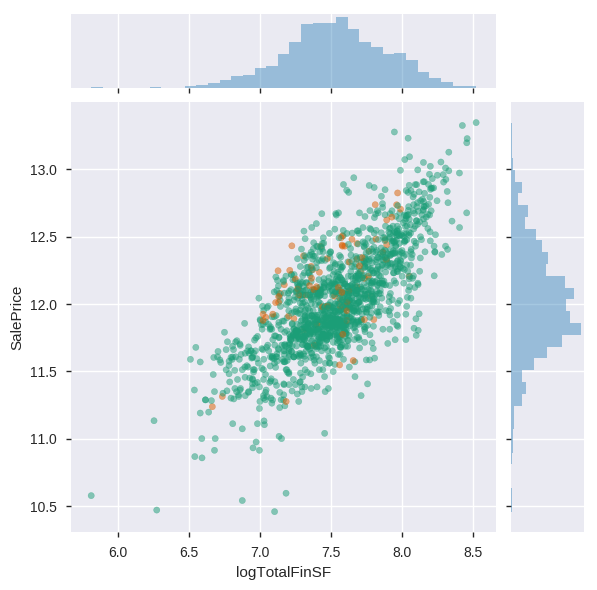

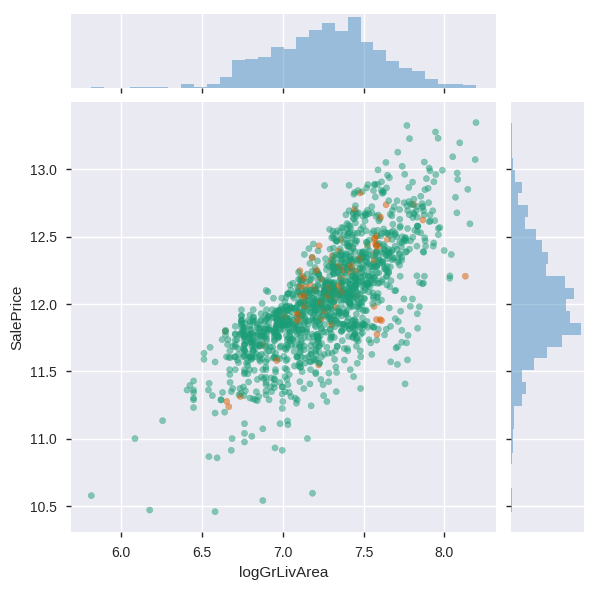

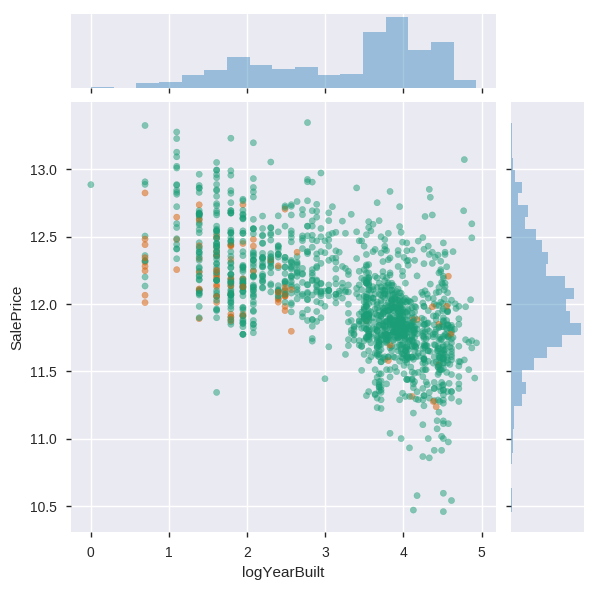

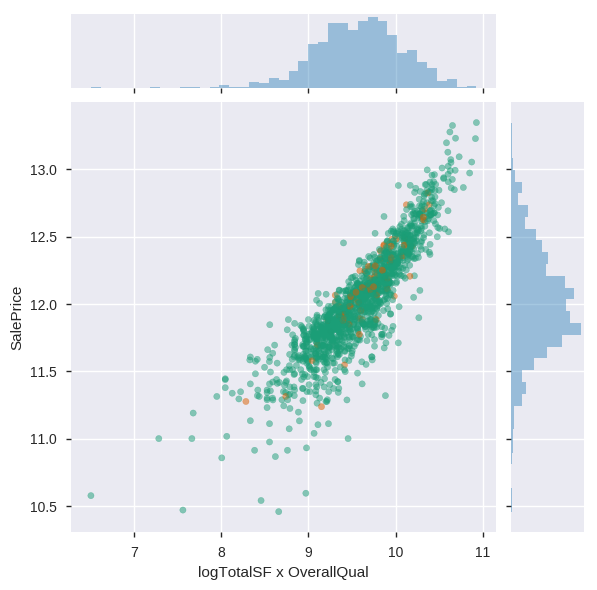

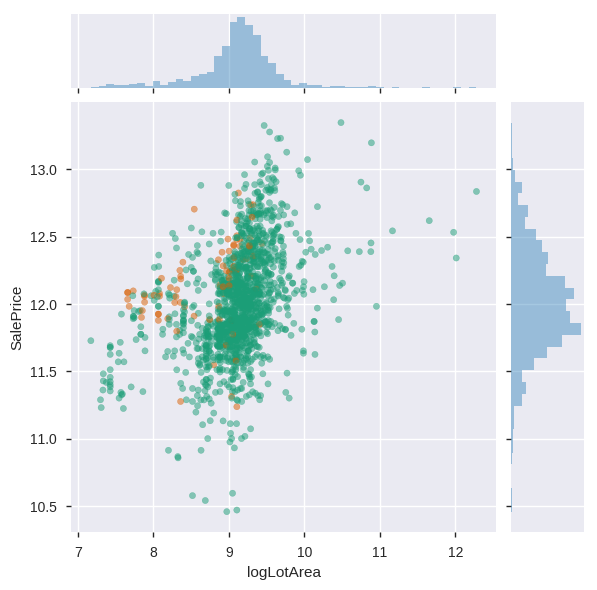

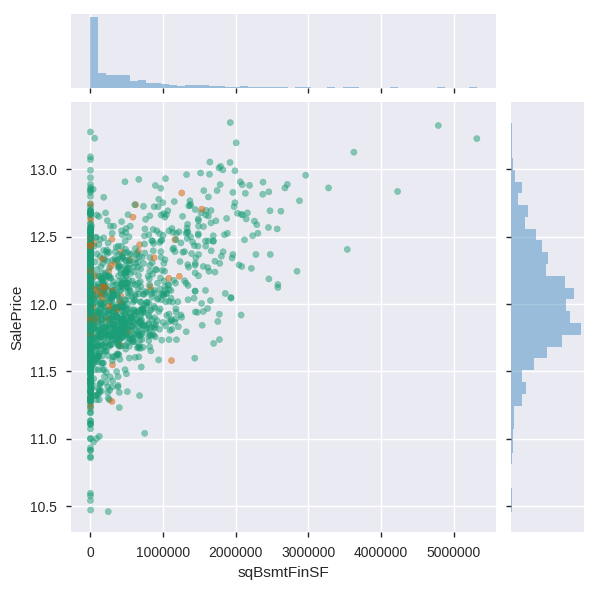

In [48]:
# few charts

response = 'SalePrice'
z = df.loc[~df["SalePrice"].isna()]

norm = matplotlib.colors.Normalize(vmin=0, vmax=21, clip=True)
mapper = plt.cm.ScalarMappable(norm=norm, cmap=plt.cm.Dark2)
colordict = {k: i for i, k in enumerate(z['MSZoning'].unique())}

for var in ['logTotalFinSF','logGrLivArea','logYearBuilt','logTotalSF x OverallQual','logLotArea','sqBsmtFinSF',]:
    sns.jointplot(var, 
                  response, 
                  data=z, 
                  alpha=0.5, 
                  s=20, 
                  joint_kws={"color": z['MSZoning'].apply(lambda x: matplotlib.colors.to_hex(mapper.to_rgba(colordict[x])))}
                 )
    


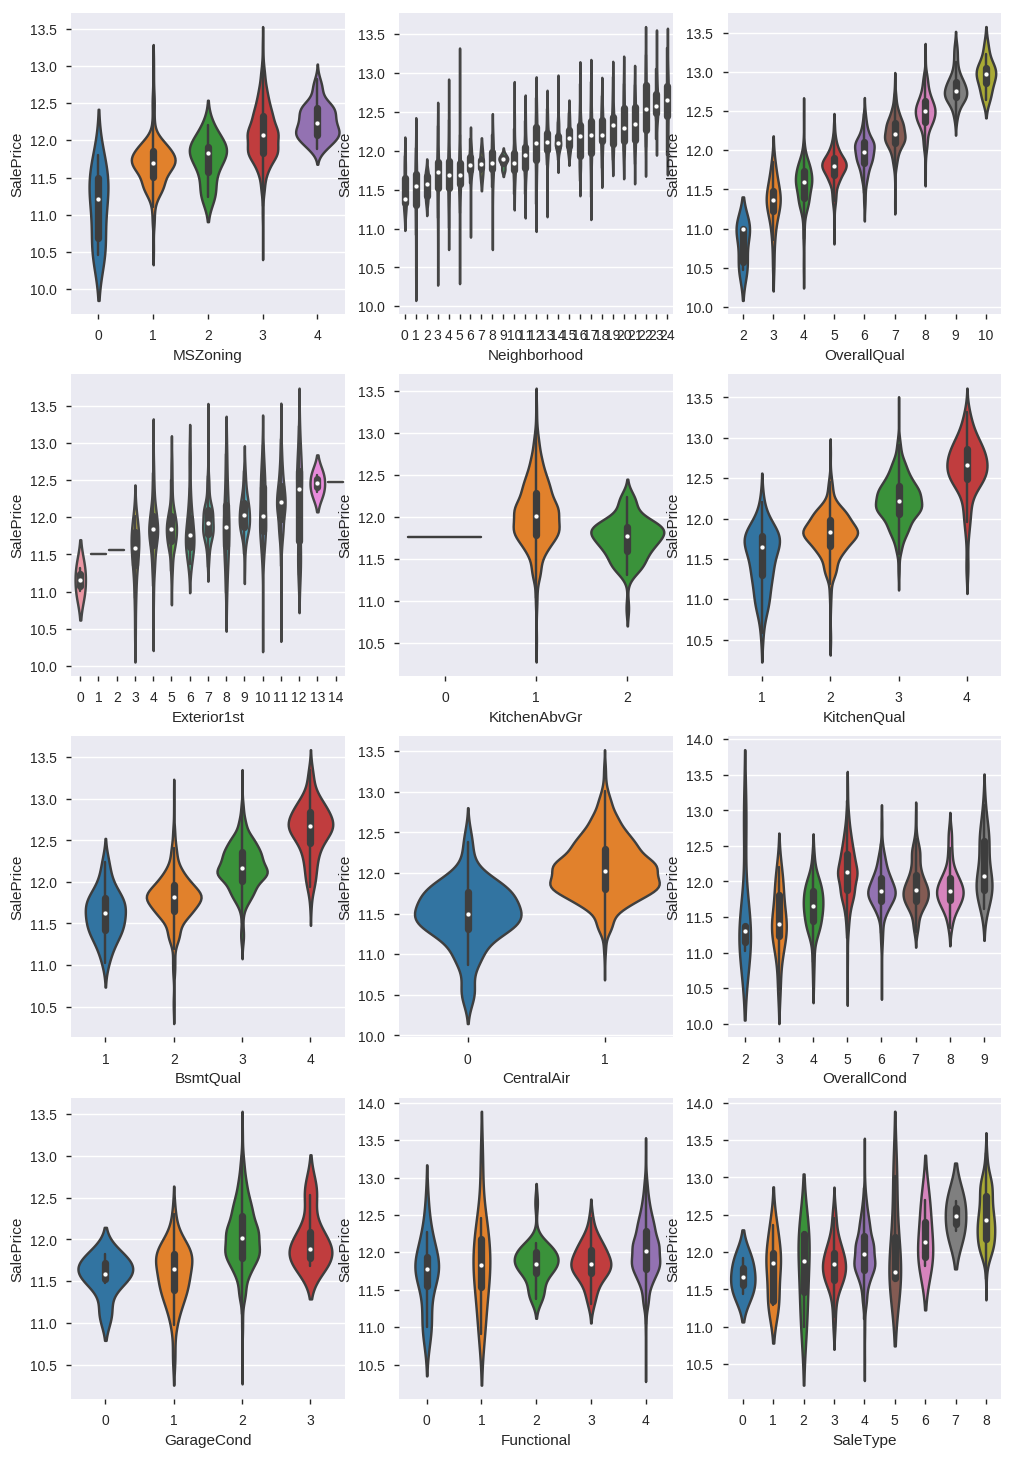

In [49]:
fig, ax = plt.subplots(figsize=(12,18), ncols=3, nrows=4)

for i, var in enumerate(['MSZoning','Neighborhood','OverallQual','Exterior1st','KitchenAbvGr','KitchenQual',
                         'BsmtQual', 'CentralAir','OverallCond','GarageCond','Functional','SaleType',]):
    sns.violinplot(x=var, y=response, data=z, ax = ax[i // 3][i % 3])    


In [50]:
widget_cats = []
widget_nums = []

for col in df.columns:
    if col == 'SalePrice':
        continue
    cardinality = len(df[col].value_counts())
    if cardinality <= 25:
        widget_cats.append(col)
    else:
        widget_nums.append(col)
        
widget_cats.sort()        
print(widget_cats)
print()
widget_nums.sort()
print(widget_nums)

['BedroomAbvGr', 'BldgType', 'BsmtBath', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'BsmtFullBath', 'BsmtQual', 'CentralAir', 'Condition1', 'Condition2', 'Electrical', 'ExterCond', 'ExterQual', 'Exterior1st', 'Exterior2nd', 'Fence', 'FireplaceQu', 'Fireplaces', 'Foundation', 'FullBath', 'Functional', 'Functional x OverallQual', 'GarageCars', 'GarageCond', 'GarageFinish', 'GarageQual', 'GarageType', 'HalfBath', 'Heating', 'HeatingQC', 'HouseStyle', 'KitchenAbvGr', 'KitchenQual', 'LandContour', 'LandSlope', 'LotConfig', 'LotShape', 'MSSubClass', 'MSZoning', 'MasVnrType', 'MoSold', 'Neighborhood', 'OverallCond', 'OverallQual', 'PavedDrive', 'RoofMatl', 'RoofStyle', 'SaleCondition', 'SaleType', 'TotRmsAbvGrd', 'TotalBath', 'has2ndfloor', 'hasfireplace', 'logGarageRatio', 'logKitchenAbvGr x KitchenQual']

['1stFlrSF', 'AvgBltRemod', 'BsmtFinSF x BsmtBath', 'Functional x TotalFinSF', 'GarageArea', 'LotFrontage', 'MasVnrArea', 'PorchSF', 'TotalBsmtSF', 'TotalSF', 'YearRemodAd

Dropdown(description='Variable:', options=('1stFlrSF', 'AvgBltRemod', 'BsmtFinSF x BsmtBath', 'Functional x To…

Dropdown(description='Color by:', index=43, options=('BedroomAbvGr', 'BldgType', 'BsmtBath', 'BsmtCond', 'Bsmt…

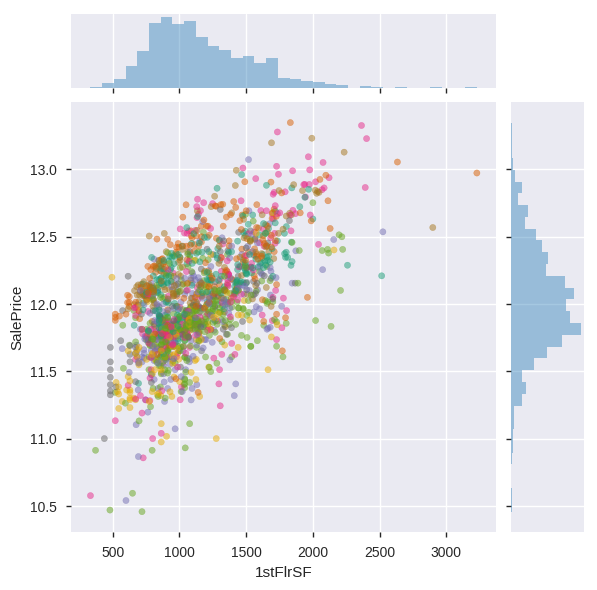

In [51]:
# interactive widget for continuous variables

do_refresh()
    


Dropdown(description='Cat:', options=('BedroomAbvGr', 'BldgType', 'BsmtBath', 'BsmtCond', 'BsmtExposure', 'Bsm…

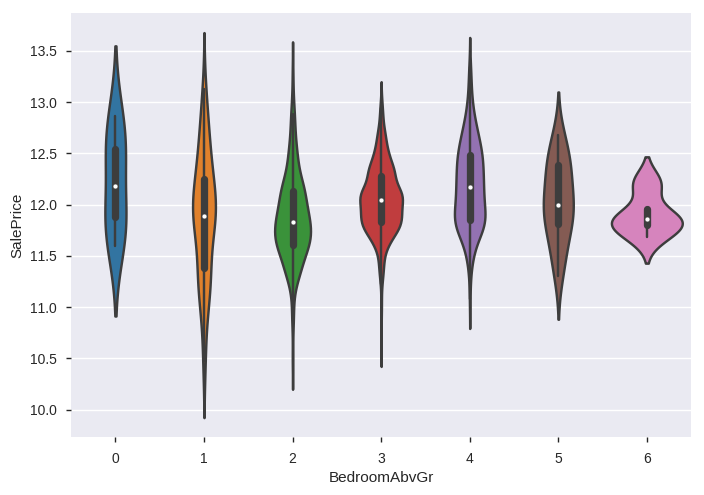

In [52]:
# interactive widget for categorical variables

def on_value_change3(change):
    do_refresh3(change['new'])

def do_refresh3(var=widget_cats[0]):

    clear_output()
    dropdown3 = widgets.Dropdown(
        options=widget_cats,
        value=var,
        description='Cat:',
        disabled=False,)
    display(dropdown3)
    dropdown3.observe(on_value_change3, names='value')
    
    response = 'SalePrice'
    z = df.loc[~df["SalePrice"].isna()]

    sns.violinplot(x=var, y=response, data=z)    

do_refresh3()
        

In [53]:
### compare correlations of log, linear, square, add transforms as necessary
### make categorical if low cardinality

z = df.loc[~df["SalePrice"].isna()]
for col in z.columns:
    if z[col].dtype not in numeric_dtypes:
        continue
    elif col=="SalePrice":
        continue
    log = (np.corrcoef(np.log1p(z[col]), z['SalePrice'])[0,1])
    linear = (np.corrcoef(z[col], z['SalePrice'])[0,1])
    square = (np.corrcoef(z[col]**2, z['SalePrice'])[0,1])
    print(col, 'log', log, 'linear', linear, 'square', square)
    
   

MSSubClass log -0.0004798907734951526 linear -0.04514451690638043 square -0.09328233312170445
MSZoning log 0.41753275148485824 linear 0.41279756852904714 square 0.3968974086646346
LandContour log 0.16278764070540458 linear 0.15709534886644297 square 0.13402513591086052
LotConfig log 0.12785450847566468 linear 0.14424571916822732 square 0.1537406785470078
Neighborhood log 0.6886270727823947 linear 0.7420311981460962 square 0.7282914789507746
Condition1 log 0.1850577692219324 linear 0.18380549468895432 square 0.14073313864977835
Condition2 log 0.09994001129659712 linear 0.11107229390058972 square 0.11426679287316456
BldgType log 0.18116649123563208 linear 0.183155943702183 square 0.17511133594202238
HouseStyle log 0.11447612264187941 linear 0.1393572946258224 square 0.1696622861142495
RoofStyle log 0.20614395906459587 linear 0.20475409957822752 square 0.2027659110664456
RoofMatl log 0.0953509553670977 linear 0.10014775446612688 square 0.10324327819452739
Exterior1st log 0.417342845182334

In [54]:
# # make these strings
# transformstr = ['HeatingQC', 'BsmtQual', 'BsmtCond', 'BsmtFullBath', 'TotRmsAbvGrd', 'Fireplaces', 
#                 'GarageQual', 'TotalBath', 'BsmtBath',  'HalfBath', 'MSSubClass',]

categorical_str = ['MSSubClass', 'MSZoning', 'LandContour', 'LotConfig',
                   'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
                   'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
                   'Foundation', 'Heating', 'CentralAir', 'GarageType', 'SaleType',
                   'SaleCondition', 'LotShape', 'LandSlope', 'OverallQual', 'OverallCond',
                   'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
                   'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'Electrical',
                   'KitchenQual', 'Functional', 'FireplaceQu', 'GarageFinish',
                   'GarageQual', 'GarageCond', 'PavedDrive', 'Fence', 
                   'Fireplaces', 'GarageCars', 'MoSold', 'monthnum']

for col in df.columns:
    cardinality = df[col].value_counts().shape[0]
    if ((cardinality <= 4) and (cardinality > 2) or (col in labelencoded)):
        print(col)
        df[col] = df[col].apply(str)
        

MSZoning
LandContour
LotConfig
Neighborhood
Condition1
Condition2
BldgType
RoofStyle
RoofMatl
Exterior1st
Exterior2nd
MasVnrType
Foundation
Heating
GarageType
SaleType
SaleCondition
LotShape
LandSlope
ExterQual
ExterCond
BsmtQual
BsmtCond
HeatingQC
Electrical
KitchenQual
GarageFinish
GarageQual
GarageCond
PavedDrive
BsmtFullBath
HalfBath
KitchenAbvGr
Fireplaces


In [55]:
# transform categorical variables to dummies
print(df.shape)
df = pd.get_dummies(df)
#df = pd.get_dummies(df, drop_first=True)
print(df.shape)

(2915, 84)
(2915, 264)


In [56]:
# after dummifying, check for possible deletion or merger
low_variance = []

for i in df.columns:
    counts = df[i].value_counts()
    topval_count = counts.iloc[0]
    if topval_count / len(df) * 100 > 99.4:
        low_variance.append(i)

low_variance = list(low_variance)
low_variance

['LotConfig_3',
 'Neighborhood_7',
 'Condition1_5',
 'Condition1_6',
 'Condition2_0',
 'Condition2_1',
 'Condition2_2',
 'Condition2_3',
 'Condition2_5',
 'Condition2_6',
 'Condition2_7',
 'RoofStyle_2',
 'RoofStyle_5',
 'RoofMatl_0',
 'RoofMatl_2',
 'RoofMatl_4',
 'RoofMatl_5',
 'RoofMatl_6',
 'Exterior1st_0',
 'Exterior1st_1',
 'Exterior1st_13',
 'Exterior1st_14',
 'Exterior1st_2',
 'Exterior2nd_0',
 'Exterior2nd_12',
 'Exterior2nd_15',
 'Exterior2nd_3',
 'Exterior2nd_7',
 'Foundation_3',
 'Foundation_4',
 'Heating_0',
 'Heating_1',
 'Heating_2',
 'Heating_3',
 'GarageType_1',
 'SaleType_0',
 'SaleType_2',
 'SaleType_5',
 'SaleType_6',
 'SaleType_7',
 'SaleCondition_0',
 'LandSlope_2',
 'ExterCond_4',
 'Electrical_0',
 'GarageCond_0',
 'KitchenAbvGr_0',
 'Fireplaces_3']

In [57]:
dropcols = []
for col in df.columns:
    most_frequent = df[col].value_counts().iloc[0]
    if most_frequent  >= 2910:
        dropcols.append(col)
        print(col, most_frequent)

df.drop(columns=dropcols, inplace=True)

Condition2_0 2913
Condition2_1 2910
Condition2_3 2914
Condition2_5 2914
Condition2_6 2911
Condition2_7 2912
RoofStyle_5 2910
RoofMatl_0 2914
RoofMatl_2 2914
RoofMatl_5 2914
Exterior1st_1 2913
Exterior1st_13 2913
Exterior1st_14 2914
Exterior1st_2 2913
Exterior2nd_0 2912
Exterior2nd_15 2914
Exterior2nd_3 2911
Foundation_4 2910
Heating_0 2914
Heating_3 2913
SaleType_7 2910
KitchenAbvGr_0 2912


In [58]:
# split off train, test
df_test = df.loc[df['SalePrice'].isna()]
print(df_test.shape)

df = df.loc[~df['SalePrice'].isna()]
df.shape

(1459, 242)


(1456, 242)

In [59]:
# do train test split on train
response = 'SalePrice'
predictors = [p for p in df.columns if p not in [response, 'YrSold']]

X_train, X_test, y_train, y_test = train_test_split(df[predictors], df[response], test_size=.25)

### 4. Tune 

In [60]:
def evaluate(y_train, y_pred_train, y_test, y_pred_test):
    print('Train RMSE', np.sqrt(mean_squared_error(np.expm1(y_train), np.expm1(y_pred_train))))
    print('Train R-squared', r2_score(np.expm1(y_train), np.expm1(y_pred_train)))
    print('Train MAE', mean_absolute_error(np.expm1(y_train), np.expm1(y_pred_train)))
    print()
    print('Test RMSE', np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred_test))))
    print('Test R-squared', r2_score(np.expm1(y_test), np.expm1(y_pred_test)))
    print('Test MAE', mean_absolute_error(np.expm1(y_test), np.expm1(y_pred_test)))

def evaluate2(y_train, y_pred_train, prefix = "Train"):
    print('%s RMSE (log)' % prefix, np.sqrt(mean_squared_error(y_train, y_pred_train)))
    print('%s RMSE' % prefix, np.sqrt(mean_squared_error(np.expm1(y_train), np.expm1(y_pred_train))))
    print('%s R-squared' % prefix, r2_score(np.expm1(y_train), np.expm1(y_pred_train)))
    print('%s MAE' % prefix, mean_absolute_error(np.expm1(y_train), np.expm1(y_pred_train)))
    return r2_score(np.expm1(y_train), np.expm1(y_pred_train))

In [61]:
# use 10 kfolds for CV
kfolds = KFold(n_splits=10, shuffle=True, random_state=42)


In [62]:
%%time
# linear regression

reg = LinearRegression()
reg.fit(X_train, y_train)

y_pred_train = reg.predict(X_train)
y_pred_test = reg.predict(X_test)
evaluate(y_train, y_pred_train, y_test, y_pred_test)



Train RMSE 15884.620306975483
Train R-squared 0.9594713071126398
Train MAE 10938.96657883846

Test RMSE 19934.74403714462
Test R-squared 0.9168230549188771
Test MAE 13259.160130201486
CPU times: user 196 ms, sys: 4 ms, total: 200 ms
Wall time: 50.3 ms


Train RMSE 17090.520892455843
Train R-squared 0.953084157478489
Train MAE 11378.92587168116

Test RMSE 18008.0333329659
Test R-squared 0.9321243174286901
Test MAE 11457.751664640651


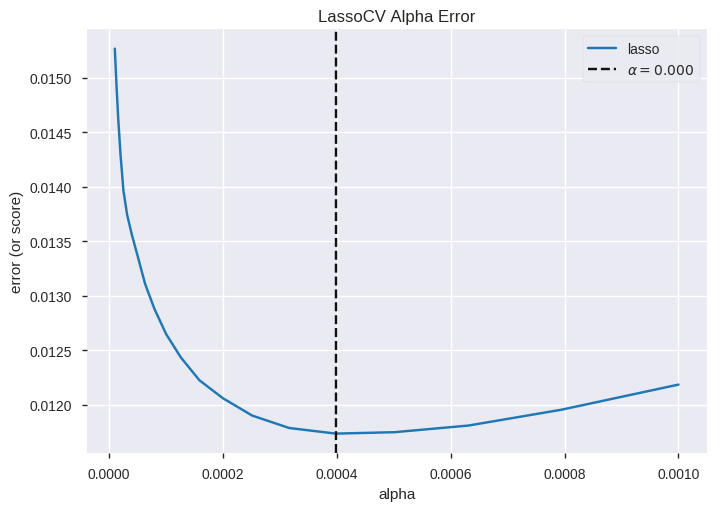

CPU times: user 14.4 s, sys: 124 ms, total: 14.5 s
Wall time: 2.94 s


In [63]:
%%time
# visualize lasso with yellowbrick
scaler = use_transform()
scaler.fit(X_train)
X_tr = scaler.transform(X_train)

#alphas = np.logspace(-5, 4, 19)
alphas = np.logspace(-5, -3, 21)
visualizer = AlphaSelection(LassoCV(alphas=alphas, max_iter=20000, cv=kfolds))
visualizer.fit(X_tr, y_train)

y_pred_train = visualizer.predict(X_tr)
y_pred_test = visualizer.predict(scaler.transform(X_test))
evaluate(y_train, y_pred_train, y_test, y_pred_test)

visualizer.poof()

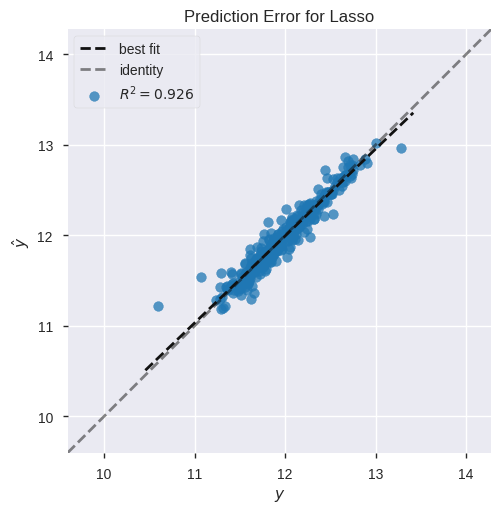

CPU times: user 620 ms, sys: 16 ms, total: 636 ms
Wall time: 160 ms


In [64]:
%%time
visualizer = PredictionError(Lasso(alpha=0.00039810717055349735))
visualizer.fit(X_tr, y_train)
visualizer.score(scaler.transform(X_test), y_test)
visualizer.poof()

In [65]:
%%time
# tune LassoCV search space
# note train error is worse when using lasso regularization but test is better
# regularization reduces overfitting

lasso = make_pipeline(use_transform(),
                         LassoCV(alphas=np.logspace(-4, -2, 11),
                                 max_iter=100000,
                                 cv=kfolds))

lasso.fit(X_train, y_train)

y_pred_train = lasso.predict(X_train)
y_pred_test = lasso.predict(X_test)
evaluate(y_train, y_pred_train, y_test, y_pred_test)
print('alpha', lasso._final_estimator.alpha_)

Train RMSE 17090.520892455843
Train R-squared 0.953084157478489
Train MAE 11378.92587168116

Test RMSE 18008.0333329659
Test R-squared 0.9321243174286901
Test MAE 11457.751664640651
alpha 0.00039810717055349735
CPU times: user 1.42 s, sys: 4 ms, total: 1.42 s
Wall time: 356 ms


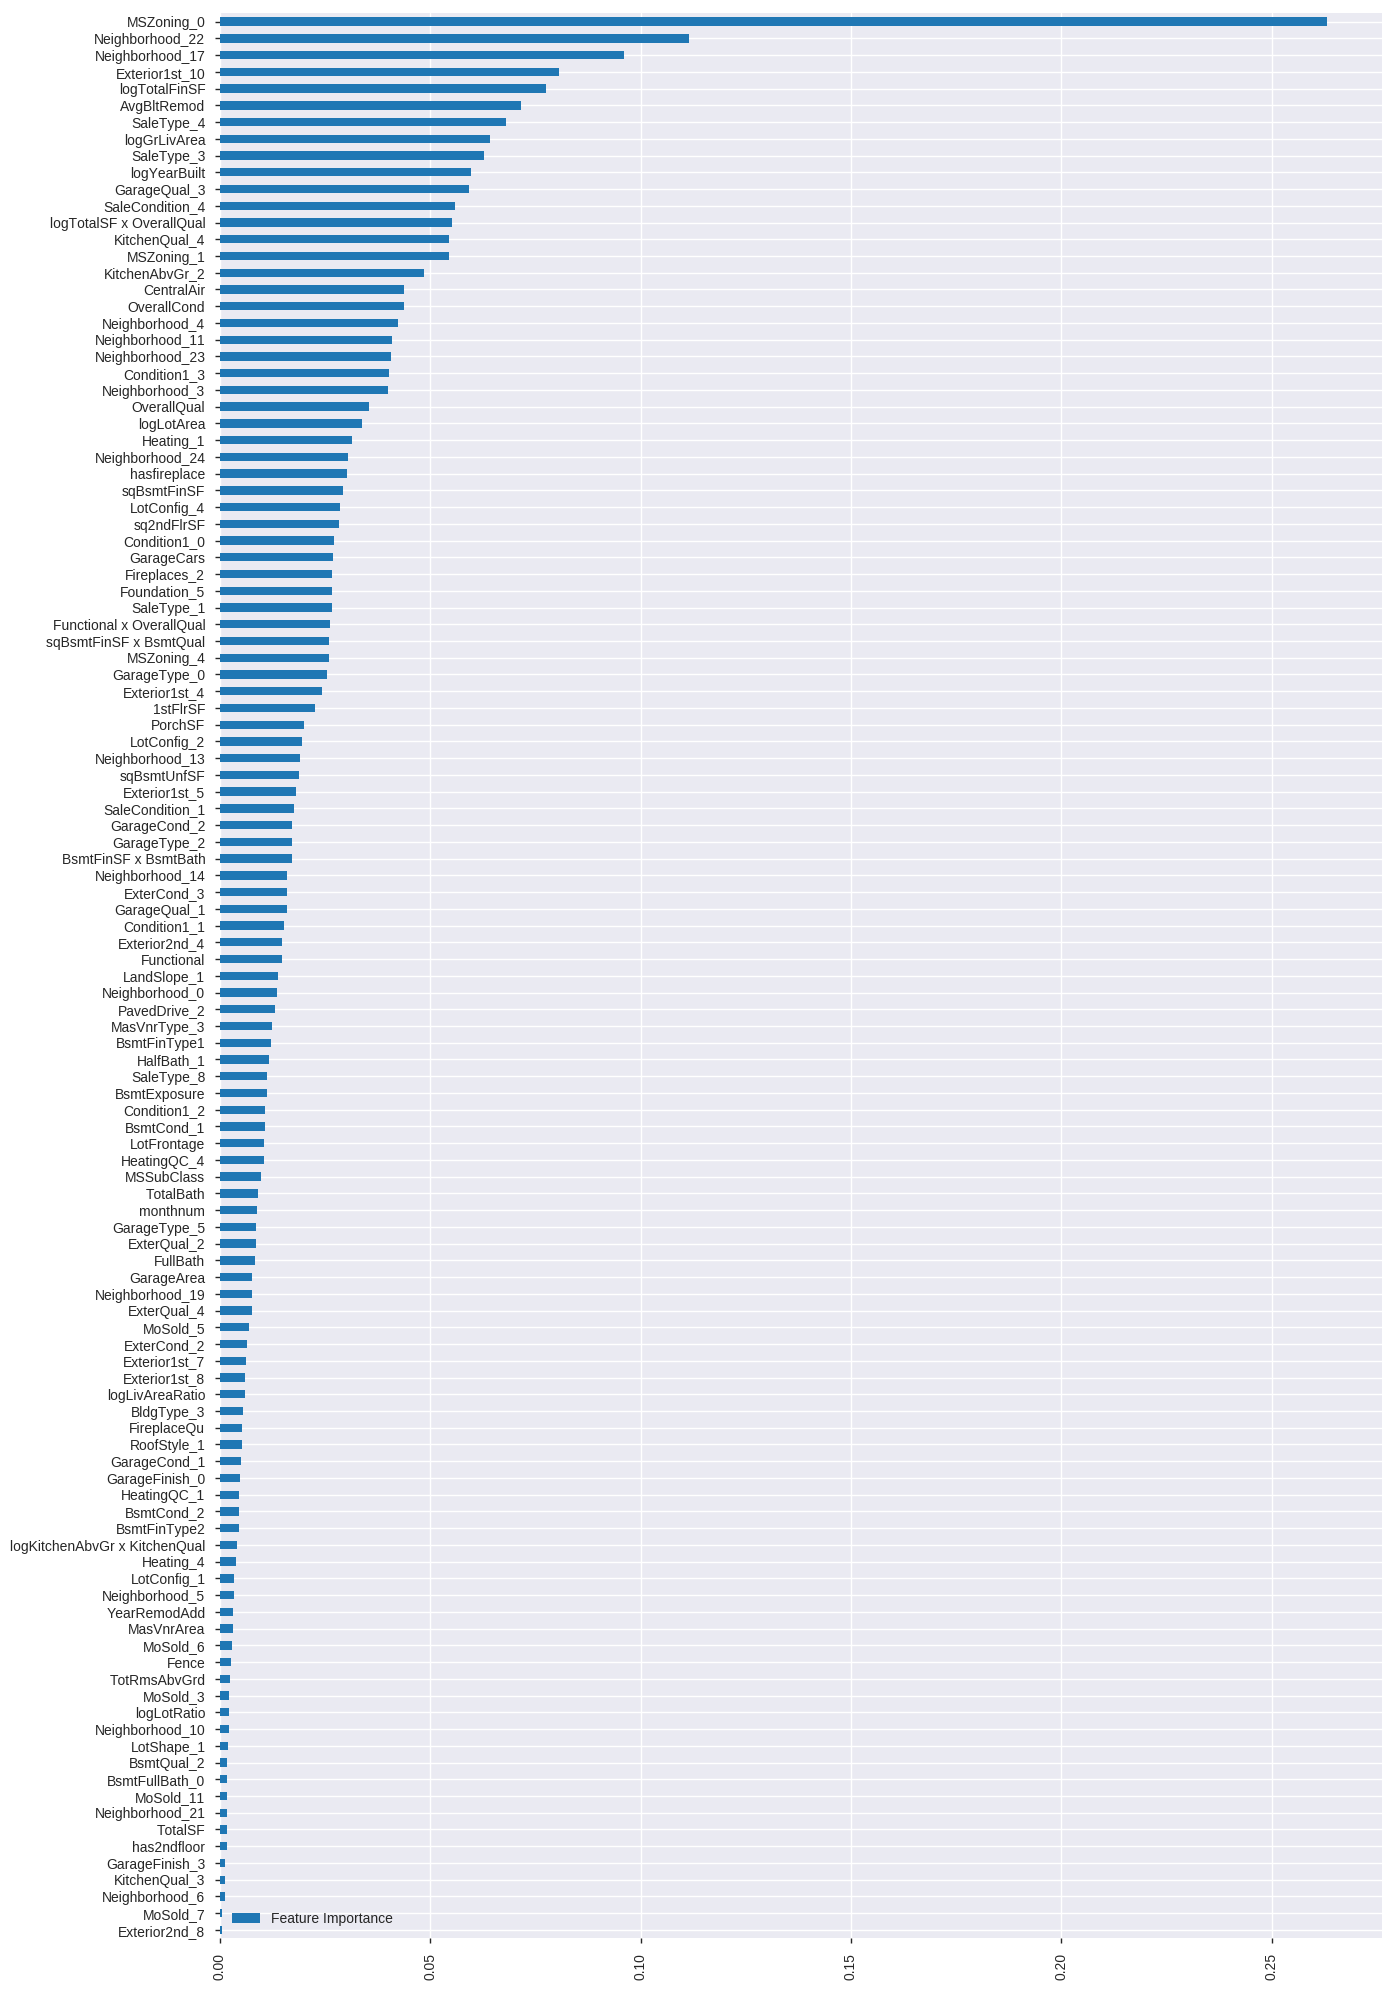

In [66]:
imp_lasso = pd.DataFrame({"Feature Importance" : lasso._final_estimator.coef_}, index=predictors)
imp_lasso["Feature Importance"]=abs(imp_lasso["Feature Importance"])
imp_lasso[imp_lasso["Feature Importance"]!=0].sort_values("Feature Importance").plot(kind="barh",figsize=(15,25))
plt.xticks(rotation=90)
plt.show()

Train RMSE 17007.801055193613
Train R-squared 0.9535372131788313
Train MAE 11410.808945443252

Test RMSE 18235.092559985806
Test R-squared 0.9304018681545295
Test MAE 11503.811237650072


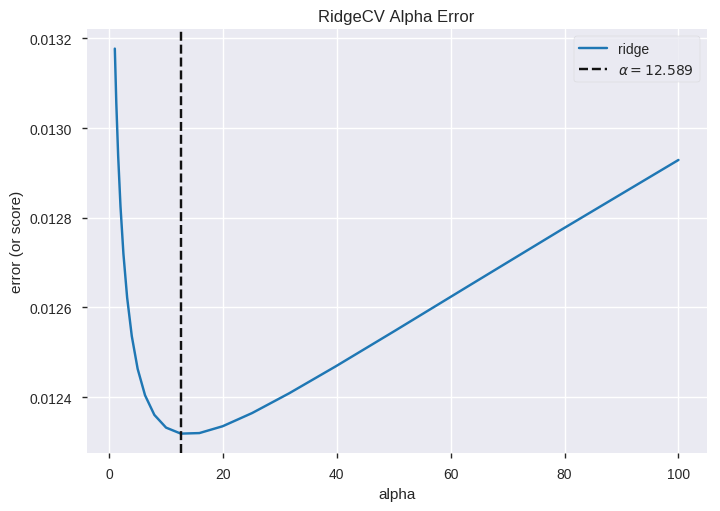

CPU times: user 580 ms, sys: 20 ms, total: 600 ms
Wall time: 175 ms


In [67]:
%%time
# visualize ridge with yellowbrick
scaler = use_transform()
scaler.fit(X_train)
X_tr = scaler.transform(X_train)

#alphas = np.logspace(-2, 3, 11)
alphas = np.logspace(0, 2, 21)
visualizer = AlphaSelection(RidgeCV(alphas=alphas))
visualizer.fit(X_tr, y_train)

y_pred_train = visualizer.predict(X_tr)
y_pred_test = visualizer.predict(scaler.transform(X_test))
evaluate(y_train, y_pred_train, y_test, y_pred_test)

visualizer.poof()

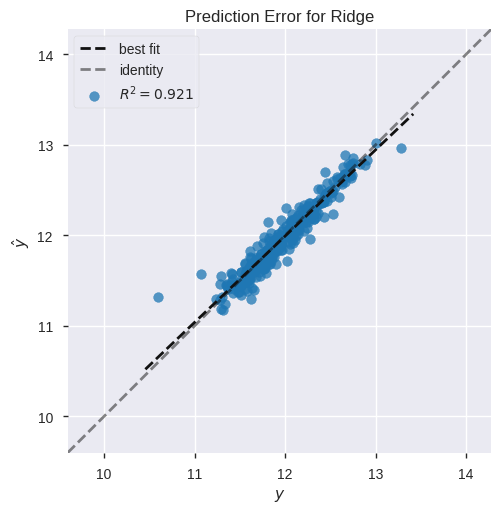

CPU times: user 484 ms, sys: 8 ms, total: 492 ms
Wall time: 123 ms


In [68]:
%%time
visualizer = PredictionError(Ridge(alpha=15.848931924611142))
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.poof()

In [69]:
%%time
# tune RidgeCV search space
alphas = np.logspace(0, 2, 21)

ridge = make_pipeline(use_transform(),
                         RidgeCV(cv=kfolds, alphas=alphas))

ridge.fit(X_train, y_train)

y_pred_train = ridge.predict(X_train)
y_pred_test = ridge.predict(X_test)
evaluate(y_train, y_pred_train, y_test, y_pred_test)
print('alpha', ridge._final_estimator.alpha_)

Train RMSE 17007.80105519538
Train R-squared 0.9535372131788217
Train MAE 11410.808945442612

Test RMSE 18235.09255998748
Test R-squared 0.9304018681545168
Test MAE 11503.811237649094
alpha 12.589254117941675
CPU times: user 3.77 s, sys: 32 ms, total: 3.8 s
Wall time: 803 ms


In [70]:
%%time
# Tune ElasticNetCV search space for alphas and l1_ratio
print("ElasticNetCV")

elasticnet = make_pipeline(use_transform(),
                           ElasticNetCV(max_iter=100000, 
                                        #l1_ratio=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99],
                                        l1_ratio=np.linspace(0.6, 0.8, 21),
                                        alphas=np.logspace(-4, -2, 21),
                                        cv=kfolds))
elasticnet.fit(X_train, y_train)

y_pred_train = elasticnet.predict(X_train)
y_pred_test = elasticnet.predict(X_test)
evaluate(y_train, y_pred_train, y_test, y_pred_test)
print('l1_ratio', elasticnet._final_estimator.l1_ratio_)
print('alpha', elasticnet._final_estimator.alpha_)


ElasticNetCV
Train RMSE 17105.38749217162
Train R-squared 0.9530025002352801
Train MAE 11386.805636429524

Test RMSE 17997.945530740213
Test R-squared 0.9322003417968864
Test MAE 11447.742187701795
l1_ratio 0.8
alpha 0.0005011872336272725
CPU times: user 54.4 s, sys: 632 ms, total: 55 s
Wall time: 11 s


In [71]:
%%time
# tune KernelRidge
print("KernelRidge")

kralphas = np.logspace(-5,0,11)
kralpha = 0.1

# linear, poly
# degree 1,2,3
coef0s = np.linspace(1,10, 19)
coef0=6

krdegrees = [1,2,3]
krdegree = 1

for i in [1]:

    kr = make_pipeline(use_transform(),
                       KernelRidge(alpha=kralpha, kernel='poly', degree=krdegree, coef0=coef0)
                      )
    print(kr)
    kr.fit(X_train, y_train)

    y_pred_train = kr.predict(X_train)
    y_pred_test = kr.predict(X_test)
    evaluate(y_train, y_pred_train, y_test, y_pred_test)
    print()

KernelRidge
Pipeline(memory=None,
         steps=[('robustscaler',
                 RobustScaler(copy=True, quantile_range=(25.0, 75.0),
                              with_centering=True, with_scaling=True)),
                ('kernelridge',
                 KernelRidge(alpha=0.1, coef0=6, degree=1, gamma=None,
                             kernel='poly', kernel_params=None))],
         verbose=False)
Train RMSE 17542.136080298467
Train R-squared 0.9505719050717233
Train MAE 11756.758019359988

Test RMSE 18144.56619765797
Test R-squared 0.9310911793441774
Test MAE 11481.476279520239

CPU times: user 432 ms, sys: 8 ms, total: 440 ms
Wall time: 88.8 ms


In [72]:
%%time
# tune SVR
print("SVR")

Cs = np.logspace(0,2,5)
C = 10.0

epsilons = np.logspace(-5,0,11)
epsilon = 0.03162277660168379

svrgammas = np.logspace(-5,0,11)
svrgamma = 0.001

#for svrgamma in svrgammas:

svr = make_pipeline(use_transform(),
                    SVR(kernel='rbf', 
    #                        degree=3, 
                        gamma=svrgamma,
    #                        coef0=0.0, 
    #                        tol=0.001, 
                        C=C, 
                        epsilon=epsilon, 
    #                        shrinking=True, 
    #                        cache_size=200, 
    #                        verbose=False, 
    #                        max_iter=-1))
                       ))
print(svr)
svr.fit(X_train, y_train)

y_pred_train = svr.predict(X_train)
y_pred_test = svr.predict(X_test)
evaluate(y_train, y_pred_train, y_test, y_pred_test)


SVR
Pipeline(memory=None,
         steps=[('robustscaler',
                 RobustScaler(copy=True, quantile_range=(25.0, 75.0),
                              with_centering=True, with_scaling=True)),
                ('svr',
                 SVR(C=10.0, cache_size=200, coef0=0.0, degree=3,
                     epsilon=0.03162277660168379, gamma=0.001, kernel='rbf',
                     max_iter=-1, shrinking=True, tol=0.001, verbose=False))],
         verbose=False)
Train RMSE 14323.021905403552
Train R-squared 0.9670482690449889
Train MAE 8904.83674615464

Test RMSE 17898.393556321927
Test R-squared 0.9329483074839632
Test MAE 11326.604704407304
CPU times: user 1.25 s, sys: 20 ms, total: 1.27 s
Wall time: 596 ms


In [73]:
%%time
# tune Gradient Boost
print("Gradient Boost")
gbestimatorss = np.logspace(2,4,9)
gbestimators = 5623
gbdepth = 2
gblearnrate = 0.01

for i in [1]:
                           
    gb = GradientBoostingRegressor(n_estimators=int(gbestimators), 
                                   learning_rate=gblearnrate,
                                   max_depth=gbdepth, 
                                   max_features='sqrt',
                                   min_samples_leaf=16, 
                                   loss='huber', 
                                   subsample=0.8, 
                                   random_state=42)
    print(gb)
    gb.fit(X_train, y_train)
    
    y_pred_train = gb.predict(X_train)
    y_pred_test = gb.predict(X_test)
    evaluate(y_train, y_pred_train, y_test, y_pred_test)
    print()


Gradient Boost
GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.01, loss='huber', max_depth=2,
                          max_features='sqrt', max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=16, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=5623,
                          n_iter_no_change=None, presort='auto',
                          random_state=42, subsample=0.8, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)
Train RMSE 14412.665424855539
Train R-squared 0.9666345081819171
Train MAE 8793.145460315984

Test RMSE 16509.941648636963
Test R-squared 0.9429477581068969
Test MAE 10983.972850977052

CPU times: user 5.55 s, sys: 16 ms, total: 5.56 s
Wall time: 5.56 s


In [74]:
%%time
# tune XGBoost
print("XGBoost")
# XGboost - most sophisticated decision tree model
# tuned sequentially
# no log1p

#n_estimators_xgb: number of base learner trees
n_estimators_xgbs=[100, 178, 316, 562, 1000, 1778, 3162, 5623, 10000]
n_estimators_xgb = 5623

#max_depth: max depth per base tree
max_depths = range(2,12)
max_depth = 3

#subsample: row subsampling rate (similar to RF)
subsamples = np.linspace(0.4, 0.8, 9)
subsample = 0.55

#colsample_bytree: feature subsampling rate (similar to RF)
colsample_bytrees = np.linspace(0.1, 0.8, 15)
colsample_bytree = 0.1

reg_alphas = np.logspace(-7, 0, 15)
reg_alpha = 3.1622776601683795e-06

gammas = [0, 1, 5]
gammas = [0]
gamma = 0

#learning_rate_xgb: shrinkage factor applied to each base tree update
learning_rate_xgbs = np.logspace(-2, 0, 5)
learning_rate_xgbs = [0.01]
learning_rate_xgb = 0.01

for learning_rate_xgb in learning_rate_xgbs:
 
        xgb = XGBRegressor(
            max_depth=max_depth,
            n_estimators=n_estimators_xgb,
            gamma=gamma,
            subsample=subsample,
            colsample_bytree=colsample_bytree,
            learning_rate=learning_rate_xgb,
            min_child_weight=0,
            reg_alpha=reg_alpha,
            n_jobs=-1)
    
        display(xgb)
    
        scores = np.sqrt(-cross_val_score(xgb, df[predictors], df[response],
                                      scoring="neg_mean_squared_error",
                                      cv=kfolds))
        
        print("CV Score %.04f (STD %.04f)" % (np.mean(scores), np.std(scores)))
        print()

xgb.fit(X_train, y_train.values.reshape(-1))
y_pred_train = xgb.predict(X_train)
y_pred_test = xgb.predict(X_test)
evaluate(y_train, y_pred_train, y_test, y_pred_test)


XGBoost


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=0.1, gamma=0, importance_type='gain',
             learning_rate=0.01, max_delta_step=0, max_depth=3,
             min_child_weight=0, missing=None, n_estimators=5623, n_jobs=-1,
             nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=3.1622776601683796e-06, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=True, subsample=0.55)

CV Score 0.1097 (STD 0.0132)

Train RMSE 6875.232545965564
Train R-squared 0.9924075191502454
Train MAE 4980.531214228482

Test RMSE 17690.21802376189
Test R-squared 0.9344989881344556
Test MAE 11480.511536315249
CPU times: user 10min 31s, sys: 10 s, total: 10min 41s
Wall time: 1min 17s


In [75]:
%%time
# tune LightGBM
print("LightGBM")
#n_estimators_lgbm: number of base learner trees
n_estimators_lgbms=[100, 178, 316, 562, 1000, 1778, 3162, 5623, 10000]
n_estimators_lgbm = 5623

#max_depth: max depth per base tree
num_leavess = range(2,12)
num_leaves = 6

#subsample: row subsampling rate (similar to RF)
bagging_fractions = np.linspace(0.6, 0.8, 9)
bagging_fraction = 0.75

#colsample_bytree: feature subsampling rate (similar to RF)
feature_fractions = np.linspace(0.05, 0.3, 26)
feature_fraction = 0.1

#learning_rate: shrinkage factor applied to each base tree update
learning_rates = np.logspace(-3, 0, 7)
learning_rates = [0.01]
learning_rate_lgbm = 0.01

for learning_rate_lgbm in learning_rates:
    print(num_leaves,
          n_estimators_lgbm,
          bagging_fraction,
          feature_fraction,
         )
    
    lgbm = LGBMRegressor(objective='regression',
                         num_leaves=num_leaves,
                         learning_rate=learning_rate_lgbm,
                         n_estimators=n_estimators_lgbm,
                         max_bin=200,
                         bagging_fraction=bagging_fraction,
                         feature_fraction=feature_fraction,
                         feature_fraction_seed=7,
                         min_data_in_leaf=2,
                         verbose=-1,
                         )
    
    scores = np.sqrt(-cross_val_score(lgbm, df[predictors], df[response],
                                      scoring="neg_mean_squared_error",
                                      cv=kfolds))
    
    print("CV Score %.04f (STD %.04f)" % (np.mean(scores), np.std(scores)))

    print()

lgbm.fit(X_train, y_train.values.reshape(-1))
y_pred_train = lgbm.predict(X_train)
y_pred_test = lgbm.predict(X_test)
evaluate(y_train, y_pred_train, y_test, y_pred_test)


LightGBM
6 5623 0.75 0.1
CV Score 0.1091 (STD 0.0124)

Train RMSE 6868.872862876904
Train R-squared 0.9924215589486791
Train MAE 5006.658410574123

Test RMSE 17734.309005331124
Test R-squared 0.9341720726692085
Test MAE 11577.478431158303
CPU times: user 9min 39s, sys: 6.89 s, total: 9min 46s
Wall time: 1min 6s


In [76]:
# tune MLPRegressor
print("MLPregressor")

activations = ['relu']
activation = 'relu'

solvers = ['lbfgs']
solver = 'lbfgs'

alphas = np.logspace(-1, 2, 7)
alphas = [3.162278]
alpha = 3.162278

learning_rates = ['invscaling']
learning_rate = 'invscaling'

nhiddenlayerss = [1,2,3]
nstartlayers = [128,]
layerspecs = product(nhiddenlayerss, nstartlayers)
layerspec = [1, 128]

results_dict = {}

paramlist = product(layerspecs, 
                    activations, 
                    solvers, 
                    alphas, 
                    learning_rates)

mlpmodels = []
for i, (layerspec, activation, solver, alpha, learning_rate) in enumerate(paramlist):
#for i in [1]:
    
    nhiddenlayers, nstartlayer = layerspec
    key = (nhiddenlayers, nstartlayer, alpha)
    mlplayers = []
    for j in range(nhiddenlayers):
        mlplayers.append(nstartlayer)
        nstartlayer = nstartlayer // 4

    print("Iteration %d: %s, %s, %s, alpha = %f, learning rate = %s" % (i,
                            str(mlplayers),
                            activation,
                            solver,
                            alpha,
                            learning_rate,
                           ))
    
    mlp = make_pipeline(use_transform(),
                        MLPRegressor(hidden_layer_sizes=mlplayers,
                                     activation=activation,
                                     solver=solver,
                                     alpha=alpha,
                                     learning_rate=learning_rate,
                                     max_iter=10000))
    
    #print(mlp)
    mlpmodels.append(mlp)
    
    try:
        scores = np.sqrt(-cross_val_score(mlp, df[predictors], df[response],
                                          scoring="neg_mean_squared_error",
                                          cv=kfolds))
        results_dict[key] = np.mean(scores)
        print("CV Score %.04f (STD %.04f)" % (np.mean(scores), np.std(scores)))
        print()
    except:
        pass

mlp.fit(X_train, y_train.values.reshape(-1))
y_pred_train = mlp.predict(X_train)
y_pred_test = mlp.predict(X_test)
try:
    evaluate(y_train, y_pred_train, y_test, y_pred_test)
except:
    pass

MLPregressor
Iteration 0: [128], relu, lbfgs, alpha = 3.162278, learning rate = invscaling
CV Score 0.1093 (STD 0.0127)

Iteration 1: [128, 32], relu, lbfgs, alpha = 3.162278, learning rate = invscaling
CV Score 0.1086 (STD 0.0125)

Iteration 2: [128, 32, 8], relu, lbfgs, alpha = 3.162278, learning rate = invscaling
CV Score 0.1096 (STD 0.0119)

Train RMSE 12032.582482200798
Train R-squared 0.976744449976713
Train MAE 7908.242349849634

Test RMSE 17524.79248887322
Test R-squared 0.9357182921615078
Test MAE 11415.049761298545


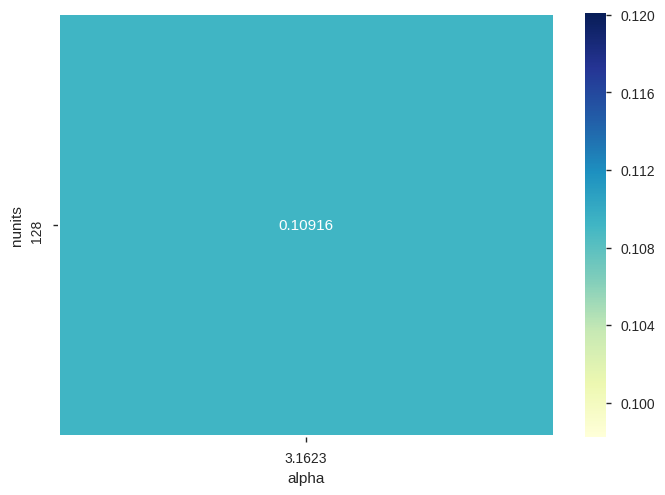

In [77]:
mlp_matrix = pd.DataFrame({
    'nlayers' : [k[0] for k in results_dict.keys()],
    'nunits' : [k[1] for k in results_dict.keys()],
    'alpha' : [np.round(k[2],4) for k in results_dict.keys()],
    'score' : [s for s in results_dict.values()],
})

mlp_pivot = mlp_matrix.pivot_table(index='nunits', 
                                   columns='alpha',
                                   values='score', 
                                   aggfunc='mean')

sns.heatmap(mlp_pivot, cmap="YlGnBu", linewidths=1.5, annot=True, annot_kws={'size': 11}, fmt='.5f')


### 5. Train and evaluate tuned models on full training set

In [78]:
# drop outliers with big misses before retrain on full training set, so they don't distort test for submission

#outliers = [30, 88, 462, 631, 1322]
# big raw misses 
# outliers = [687, 801, 896, 1320, 631]

outliers = [687, 801, 896, 1320, 1449, 462, 631]
df=df.reset_index(drop=True)
print(df.loc[outliers]['SalePrice'])
print(np.expm1(df.loc[outliers]['SalePrice']))

687     12.879020
801     13.275829
896     13.323929
1320    11.898195
1449    11.344519
462     11.041064
631     11.320566
Name: SalePrice, dtype: float64
687     392000.0
801     582933.0
896     611657.0
1320    147000.0
1449     84500.0
462      62383.0
631      82500.0
Name: SalePrice, dtype: float64


In [79]:
print(df[predictors].shape)
df.drop(outliers, inplace=True)
# if you don't reset index here, then on assigment of model results some indexes don't line up and you get NAs 
df=df.reset_index(drop=True)
print(df[predictors].shape)
df.tail()

(1456, 241)
(1449, 241)


MSSubClass  HouseStyle  CentralAir  OverallQual  OverallCond  \
1444          60           5           1            6            5   
1445          20           0           1            6            6   
1446          70           5           1            7            9   
1447          20           0           1            5            6   
1448          20           0           1            5            6   

      BsmtExposure  BsmtFinType1  BsmtFinType2  Functional  FireplaceQu  \
1444             1             1             1           4            2   
1445             1             5             4           3            2   
1446             1             6             1           4            3   
1447             2             6             4           4            2   
1448             1             3             2           4            2   

      Fence  logYearBuilt  YearRemodAdd  FullBath  BedroomAbvGr  TotRmsAbvGrd  \
1444      0      2.484907            10         2             3             7   
1445      3      3.496508            22         2             3             7   
1446      4      4.248495             4         2             4             9   
1447      0      4.110874            14         1             2             5   
1448      0      3.828641            45         1             3             6   

      logGarageYrBlt  GarageCars  LotFrontage  logLotArea  MasVnrArea  \
1444        2.484907           2         62.0    8.976894         0.0   
1445        3.496508           2         85.0    9.486152       119.0   
1446        4.248495           1         66.0    9.109746         0.0   
1447        4.110874           1         68.0    9.181735         0.0   
1448        3.828641           1         75.0    9.204121         0.0   

      sqBsmtUnfSF  TotalBsmtSF  1stFlrSF  sq2ndFlrSF  logGrLivArea  \
1444     908209.0        953.0       953      481636      7.407318   
1445     346921.0       1542.0      2073           0      7.637234   
1446     769129.0       1152.0      1188     1327104      7.758333   
1447          0.0       1078.0      1078           0      6.983790   
1448      18496.0       1256.0      1256           0      7.136483   

      GarageArea  SalePrice  logTotalFinSF  TotalSF  sqBsmtFinSF  PorchSF  \
1444       460.0  12.072547       7.407318   2600.0          0.0       40   
1445       500.0  12.254868       8.015327   3615.0     908209.0      349   
1446       252.0  12.493133       7.869402   3492.0      75625.0       60   
1447       240.0  11.864469       7.676474   2156.0    1162084.0      478   
1448       276.0  11.901590       7.773594   2512.0    1254400.0      804   

      TotalBath  BsmtBath  AvgBltRemod  logLivAreaRatio  logBedRatio  \
1444        2.5       0.0         10.5         0.283981     6.309918   
1445        3.0       1.0         27.0         0.242462     6.539586   
1446        2.0       0.0         36.5         0.326565     6.373320   
1447        2.0       1.0         37.0         0.200390     6.291569   
1448        2.5       1.0         45.0         0.225375     6.039461   

      logGarageRatio  logBathRatio  logLotRatio  has2ndfloor  hasfireplace  \
1444        0.510826      0.606136     4.857434            1             1   
1445        0.510826      0.693147     5.049856            0             1   
1446        0.223144      0.405465     4.927254            1             1   
1447        0.405465      0.693147     4.969098            0             0   
1448        0.287682      0.606136     4.894052            0             0   

      logTotalSF x OverallQual  sqBsmtFinSF x BsmtQual  BsmtFinSF x BsmtBath  \
1444                  9.655090                     0.0                   0.0   
1445                  9.984653               8173881.0                 953.0   
1446                 10.104181                302500.0                   0.0   
1447                  9.285541               4648336.0                1078.0   
1448                  

In [80]:
# store results
full_train_df = pd.DataFrame({'log_y': df[response],
                             'true_y': np.expm1(df[response])
                             })

xval_df = pd.DataFrame({'log_y': df[response],
                       'true_y': np.expm1(df[response])
                       })

cvscores = {}


In [87]:
%%time

boost_blend =  VotingRegressor(estimators=[('xgb', xgb), ('lgbm', lgbm)])

linear_blend = VotingRegressor(estimators=[('lasso', lasso), 
                                           ('ridge', ridge), 
                                           ('elasticnet', elasticnet), 
                                           ('kr', kr)])

mlp_blend =    VotingRegressor(estimators=[('mlp0', mlpmodels[0]), 
                                           ('mlp1', mlpmodels[1]), 
                                           ('mlp2', mlpmodels[2])])

models = {
    'boost_blend'  : boost_blend, 
    'linear_blend' : linear_blend, 
    'mlp_blend' : mlp_blend,
    'gb'   : gb,
    'svr'  : svr,
}

# models = {
#     'xgb'  : xgb, 
#     'lgbm' : lgbm, 
#     'gb'   : gb,
#     'svr'  : svr,
#     'kr'   : kr,
#     'lasso': lasso,
#     'ridge': ridge,
#     'elasticnet' : elasticnet
# }

#for i,m in enumerate(mlpmodels):
#    models['mlp%d' %i] = m
    
for k, m in models.items():
    print(datetime.datetime.now(), k)
    # xval predictions
    xval_df[k] = cross_val_predict(m, df[predictors], df[response], cv=kfolds)

    # cross-val score
    cvscores[k] = np.sqrt(mean_squared_error(xval_df['log_y'], xval_df[k]))
    print("CV Score %.04f" % (cvscores[k]))

    # full train
    m.fit(df[predictors], df[response])
    full_train_df[k] = m.predict(df[predictors])
    
    print()

2019-05-22 23:18:36.316131 boost_blend
CV Score 0.1048

2019-05-22 23:20:58.181907 linear_blend
CV Score 0.1011

2019-05-22 23:23:19.309350 mlp_blend
CV Score 0.1010

2019-05-22 23:28:32.314668 gb
CV Score 0.1044

2019-05-22 23:29:37.902349 svr
CV Score 0.1004

CPU times: user 1h 2min 49s, sys: 47.5 s, total: 1h 3min 36s
Wall time: 11min 6s


In [82]:
#fig, ax = plt.subplots(figsize=(10,50))
#
#plot_importance(xgb,max_num_features=300, height=0.4, ax=ax, importance_type='gain');

In [83]:
# imp_lasso = pd.DataFrame({"Feature Importance" : lasso._final_estimator.coef_}, index=predictors)
# imp_lasso["Feature Importance"]=abs(imp_lasso["Feature Importance"])
# imp_lasso[imp_lasso["Feature Importance"]!=0].sort_values("Feature Importance").plot(kind="barh",figsize=(15,25))
# plt.xticks(rotation=90)
# plt.show()

### 6. Stack and Blend

In [89]:
# stack models
# with use_features_in_secondary I think we need to scale 
stack = make_pipeline(use_transform(),
                         StackingCVRegressor(regressors=[boost_blend, linear_blend, mlp_blend, gb, svr, ],
                                             meta_regressor=xgb,
                                             cv=kfolds,
                                             use_features_in_secondary=True))


In [90]:
%%time
print(datetime.datetime.now(), "stack xval")
xval_df['stack'] = cross_val_predict(stack, df[predictors].values, df[response].values, cv=kfolds)
print(datetime.datetime.now(), "xval finished")

# compute crossval score
cvscores['stack'] = np.sqrt(mean_squared_error(xval_df['log_y'], xval_df['stack']))
print(datetime.datetime.now(), "stack crossval score %.6f" % cvscores['stack'])

print(datetime.datetime.now(), "full train")
stack.fit(df[predictors].values, df[response].values)
full_train_df['stack'] = stack.predict(df[predictors].values)
print(datetime.datetime.now(), "full train finished")


2019-05-22 23:30:11.907451 stack xval
2019-05-23 01:19:45.185320 xval finished
2019-05-23 01:19:45.186349 stack crossval score 0.104229
2019-05-23 01:19:45.186436 full train
2019-05-23 01:31:29.309936 full train finished
CPU times: user 11h 47min 41s, sys: 9min 9s, total: 11h 56min 51s
Wall time: 2h 1min 17s


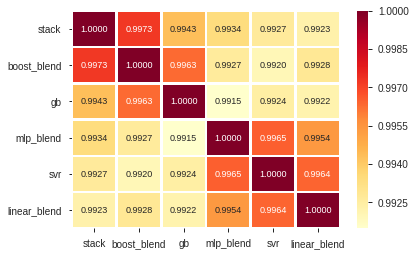

In [98]:
blendpredictors = ['stack', 'boost_blend', 'gb', 'mlp_blend', 'svr', 'linear_blend', ]
xval_corr = xval_df[blendpredictors].corr()
sns.heatmap(xval_corr, cmap="YlOrRd", linewidths=1.5, annot=True, annot_kws={'size': 9}, fmt='.4f');


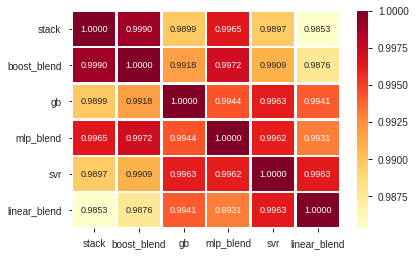

In [99]:
full_train_corr = full_train_df[['stack', 'boost_blend', 'gb', 'mlp_blend', 'svr', 'linear_blend', ]].corr()
sns.heatmap(full_train_corr, cmap="YlOrRd", linewidths=1.5, annot=True, annot_kws={'size': 9}, fmt='.4f');


In [100]:
#%%time
# blend stacked model with individual models using a weighted average.
# first equal-weight average the similar models: linear vs. boosting
# then fit a linear model to the remaining models
# get a weighted avg of all models, no intercept, positive coefs
# on further review, fit_intercept=False screws it up, puts all weight on 1st model, seems like a bug 

# since individual regressors are pipelines that do scaling
# and the metaregressor doesn't use features
# shouldn't need to transform

# note - this should do the same,
# will re-run all models instead of using xval_df (slower and less explicit)
# blendcv = StackingCVRegressor(regressors=blendpredictors,
#                               meta_regressor=blendlasso,
#                               cv=kfolds,
#                               use_features_in_secondary=False)
# blendcv.fit(df[predictors].values, df[response].values)

print(datetime.datetime.now())

# xgb and lgbm correlation > .998
# xval_df['boostblend'] = xval_df[['xgb', 'lgbm']].mean(axis=1)
# full_train_df['boostblend'] = full_train_df[['xgb', 'lgbm']].mean(axis=1)

# linear models correlation > .998
# xval_df['linearblend'] = xval_df[['elasticnet', 'ridge', 'lasso','kr']].mean(axis=1)
# full_train_df['linearblend'] = full_train_df[['elasticnet', 'ridge', 'lasso','kr']].mean(axis=1)

# 3 ML models
# xval_df['mlpblend'] = xval_df[['mlp0', 'mlp1', 'mlp2']].mean(axis=1)
# full_train_df['mlpblend'] = full_train_df[['mlp0', 'mlp1', 'mlp2']].mean(axis=1)

blendlasso = LassoCV(alphas=np.logspace(-6, -4, 5),
                     max_iter=100000,
                     cv=kfolds,
                     fit_intercept=True,
                     positive=True)
                           
blendlasso.fit(xval_df[blendpredictors],
               xval_df['log_y'])

xval_df['stackblend']=blendlasso.predict(xval_df[blendpredictors])
cvscores['stackblend'] = np.sqrt(mean_squared_error(xval_df['log_y'], xval_df['stackblend']))
print("stackblend crossval score %.6f" % cvscores['stackblend'])

full_train_df['stackblend']= blendlasso.predict(full_train_df[blendpredictors])
print("stackblend full train score %.6f" % np.sqrt(mean_squared_error(full_train_df['log_y'], 
                                                                      full_train_df['stackblend'])))


2019-05-23 08:20:56.522605
stackblend crossval score 0.098338
stackblend full train score 0.068201


In [101]:
print('coefs', dict(zip(blendpredictors,
                        list(blendlasso.coef_))))
print('coefs adjusted to sum to 1', blendlasso.coef_/np.sum(blendlasso.coef_))
print('intercept', blendlasso.intercept_)
print('sum', np.sum(blendlasso.coef_))
print('alpha', blendlasso.alpha_ )


coefs {'stack': 0.06991666609746983, 'boost_blend': 0.0, 'gb': 0.19779084399352617, 'mlp_blend': 0.226803646230674, 'svr': 0.31477623893687007, 'linear_blend': 0.20110570717931053}
intercept -0.1277194009212259
sum 1.0103931024378507
alpha 1e-06
coefs adjusted to sum to 1 [0.06919749 0.         0.19575633 0.2244707  0.31153839 0.19903709]


In [102]:
## review final CV scores

for col in xval_df.columns:
    if col in ['true_y', 'log_y', 'true_pred', 'error_stackblend']:
        continue
        
    print(col)
    evaluate2(xval_df[col], xval_df['log_y'])
    print('CV:', cvscores.get(col))
    print()


boost_blend
Train RMSE (log) 0.10479381077853964
Train RMSE 19291.69446519826
Train R-squared 0.92619356319924
Train MAE 12503.488786304008
CV: 0.10479381077853964

linear_blend
Train RMSE (log) 0.10114252751054081
Train RMSE 17829.362023470665
Train R-squared 0.9392124568040561
Train MAE 11979.24385844318
CV: 0.10114252751054081

mlp_blend
Train RMSE (log) 0.10104754744342609
Train RMSE 17652.770282110898
Train R-squared 0.9416902131261785
Train MAE 11847.891278641333
CV: 0.10104754744342609

gb
Train RMSE (log) 0.10438905428985921
Train RMSE 19177.797197965818
Train R-squared 0.9267009540063416
Train MAE 12382.328629920949
CV: 0.10438905428985921

svr
Train RMSE (log) 0.10038664271888095
Train RMSE 17798.56963377027
Train R-squared 0.9390008722997762
Train MAE 11824.602139396671
CV: 0.10038664271888095

stack
Train RMSE (log) 0.1042291739797113
Train RMSE 19411.942062880742
Train R-squared 0.9274127282986164
Train MAE 12409.93774532005
CV: 0.1042291739797113

stackblend
Train RMSE (l

In [103]:
full_train_df['error_log'] = full_train_df['stackblend'] - full_train_df['log_y']
full_train_df['true_y'] = np.expm1(full_train_df['log_y'])
full_train_df['true_pred'] = np.expm1(full_train_df['stackblend'])
full_train_df['error_stackblend'] = full_train_df['true_pred'] - full_train_df['true_y']
full_train_df.describe()


log_y         true_y  boost_blend  linear_blend    mlp_blend  \
count  1449.000000    1449.000000  1449.000000   1449.000000  1449.000000   
mean     12.021308  179666.820566    12.021358     12.021274    12.021304   
std       0.391841   74938.007771     0.385606      0.378807     0.382735   
min      10.460271   34900.000000    10.473874     10.666254    10.607904   
25%      11.775297  130000.000000    11.780245     11.766284    11.777243   
50%      12.001512  163000.000000    12.000142     12.003414    11.994687   
75%      12.271397  213500.000000    12.261953     12.269923    12.264548   
max      13.345509  625000.000000    13.323282     13.325726    13.345709   

                gb          svr        stack   stackblend    error_log  \
count  1449.000000  1449.000000  1449.000000  1449.000000  1449.000000   
mean     12.024782    12.027086    12.021335    12.021028    -0.000280   
std       0.375738     0.376901     0.387081     0.382189     0.068224   
min      10.778626    10.610712    10.539007    10.637813    -0.343626   
25%      11.776671    11.777637    11.779022    11.769111    -0.036011   
50%      11.997444    12.002485    11.998777    11.994658    -0.003463   
75%      12.258936    12.263915    12.268533    12.264186     0.028062   
max      13.231686    13.314007    13.317790    13.318190     0.557094   

           true_pred  error_stackblend  
count    1449.000000       1449.000000  
mean   179090.211525       -576.609041  
std     73459.535590      11630.900622  
min     41680.527932     -78528.389516  
25%    129198.187668      -5860.140271  
50%    161886.656687       -516.873594  
75%    211966.096683       4890.896657  
max    608157.253773      72923.922835

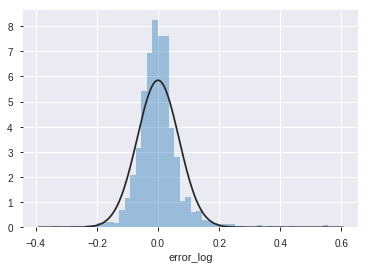

In [104]:
# plot save residuals to analyze vs. columns, interactions
residual = full_train_df[['log_y','true_y', 'true_pred', 'stackblend', 'error_stackblend', 'error_log']]
residual.reset_index(inplace=True)
residual['index'] += 1
residual.to_csv('residual_temp.csv', index=False)

sns.distplot(residual['error_log'], kde=False, fit=stats.norm)


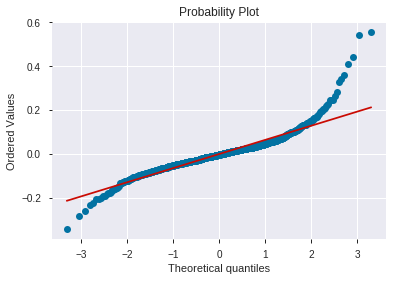

In [105]:
res = stats.probplot(residual['error_log'], plot=plt);

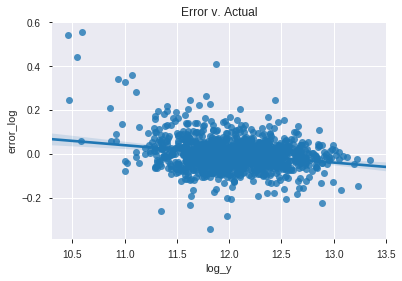

In [107]:
sns.regplot(x="log_y", y="error_log", data=residual).set_title('Error v. Actual');


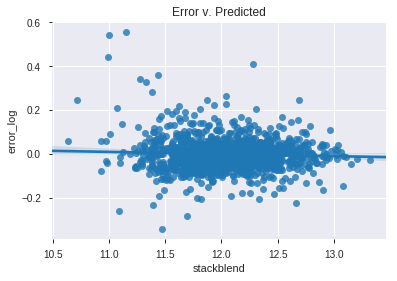

In [108]:
sns.regplot(x="stackblend", y="error_log", data=residual).set_title('Error v. Predicted');

In [109]:
full_train_df.sort_values('error_stackblend')[['true_y','true_pred','error_stackblend', 'error_log']]
full_train_df.sort_values('error_log')[['true_y','true_pred','error_stackblend', 'error_log']]


true_y      true_pred  error_stackblend  error_log
963   135000.0   95740.891483     -39259.108517  -0.343626
678   159434.0  120139.154012     -39294.845988  -0.282977
88     85000.0   65577.772352     -19422.227648  -0.259411
1115  112000.0   88768.433520     -23231.566480  -0.232465
769   395000.0  316471.610484     -78528.389516  -0.221652
13    279500.0  227936.459462     -51563.540538  -0.203935
142   166000.0  135434.943725     -30565.056275  -0.203495
487   160000.0  131063.804201     -28936.195799  -0.199488
1204  113000.0   93138.639720     -19861.360280  -0.193297
328   214500.0  177341.821567     -37158.178433  -0.190230
218   311500.0  259775.537662     -51724.462338  -0.181581
858   250580.0  209693.741497     -40886.258503  -0.178129
557   234000.0  196093.949329     -37906.050671  -0.176726
277   141000.0  118483.472912     -22516.527088  -0.173985
185   475000.0  402278.231170     -72721.768830  -0.166170
107   115000.0   97547.491432     -17452.508568  -0.164591
1413  274970.0  234560.127606     -40409.872394  -0.158949
1132  144000.0  122920.350548     -21079.649452  -0.158276
879   328900.0  281221.516449     -47678.483551  -0.156611
238   318000.0  272458.284730     -45541.715270  -0.154565
1019  167500.0  144360.415695     -23139.584305  -0.148669
1039  556581.0  480567.492241     -76013.507759  -0.146845
175   243000.0  212618.497118     -30381.502882  -0.133561
1171  154900.0  135658.032757     -19241.967243  -0.132642
1174  392500.0  343889.787049     -48610.212951  -0.132215
702   254000.0  222544.841496     -31455.158504  -0.132205
472   440000.0  387589.157223     -52410.842777  -0.126829
1161  235000.0  207045.765417     -27954.234583  -0.126645
1090  170000.0  149869.902465     -20130.097535  -0.126030
1163  171000.0  150953.053383     -20046.946617  -0.124694
...        ...            ...               ...        ...
431    79900.0   93577.863335      13677.863335   0.158016
97     94750.0  111518.263869      16768.263869   0.162945
663   129000.0  151952.863291      22952.863291   0.163757
965    99500.0  117258.424192      17758.424192   0.164221
1203  164000.0  194150.655011      30150.655011   0.168767
251   235000.0  278690.110094      43690.110094   0.170514
1136   80000.0   95013.923911      15013.923911   0.171995
767   107000.0  127912.159580      20912.159580   0.178513
1015   87000.0  104562.995002      17562.995002   0.183880
655    97500.0  117908.990434      20408.990434   0.190059
478    89471.0  108620.914943      19149.914943   0.193947
308    82500.0  100420.996216      17920.996216   0.196571
723   110000.0  134736.906074      24736.906074   0.202842
66    180000.0  220849.943989      40849.943989   0.204526
705    52000.0   64136.779700      12136.779700   0.209771
1055   90000.0  111859.435929      21859.435929   0.217431
558   121500.0  151715.766149      30215.766149   0.222093
626   135000.0  169565.102390      34565.102390   0.227961
579   253293.0  324005.312098      70712.312098   0.246212
1373  112000.0  143325.671758      31325.671758   0.246619
909    35311.0   45214.827469       9903.827469   0.247224
709   130500.0  169954.668744      39454.668744   0.264157
868    66500.0   88118.255329      21618.255329   0.281474
410    60000.0   83298.163139      23298.163139   0.328077
806    55993.0   78703.317515      22710.317515   0.340453
1422   64500.0   92359.811678      27859.811678   0.359022
586   143000.0  215923.922835      72923.922835   0.412079
961    37900.0   59085.743539      21185.743539   0.444029
494    34900.0   59938.120897      25038.120897   0.540814
30     40000.0   69824.448859      29824.448859   0.557094

[1449 rows x 4 columns]

### 7. Run on test set, export CSV for submission

In [114]:
stack = stack_cv

In [117]:
submit_df = pd.DataFrame({'stack' : stack.predict(df_test[predictors]),
                          'boost_blend' : boost_blend.predict(df_test[predictors]),
                          'gb' : gb.predict(df_test[predictors]),
                          'mlp_blend' : mlp_blend.predict(df_test[predictors]),
                          'svr' : svr.predict(df_test[predictors]),
                          'linear_blend' : linear_blend.predict(df_test[predictors]),
                         })

submit_df['stackblend'] = blendlasso.predict(submit_df[blendpredictors])

# force weights to sum to 1, no intercept
submit_df['stackblend2'] = \
     0.06919749 * submit_df['stack'] + \
     0.0        * submit_df['boost_blend'] + \
     0.19575633 * submit_df['gb']  + \
     0.2244707 * submit_df['mlp_blend'] +\
     0.31153839 * submit_df['svr'] + \
     0.19903709 * submit_df['linear_blend']

# alternate rounded weights , floor at 0.05, cap at 0.25
# the stack and a linear model are usually in the god tier, svr and gb are often up there, want to include all
submit_df['stackblend3'] = \
     0.10       * submit_df['stack'] + \
     0.05       * submit_df['boost_blend'] + \
     0.20       * submit_df['gb'] + \
     0.20       * submit_df['mlp_blend'] +\
     0.25       * submit_df['svr'] + \
     0.20       * submit_df['linear_blend'] 

submit_df


stack  boost_blend         gb  mlp_blend        svr  linear_blend  \
0     11.729428    11.743276  11.746465  11.695528  11.701159     11.661822   
1     11.955160    11.990947  11.982400  11.986267  11.994577     11.971377   
2     12.105942    12.124570  12.128591  12.146933  12.130368     12.105475   
3     12.210419    12.209141  12.187058  12.183051  12.196985     12.192235   
4     12.111927    12.136096  12.136468  12.103841  12.085152     12.092025   
5     12.073641    12.068581  12.068743  12.054917  12.060768     12.051114   
6     12.073088    12.079236  12.083946  12.097956  12.103846     12.094937   
7     12.025826    12.009559  12.025493  12.016366  11.999926     11.987296   
8     12.120979    12.142478  12.146109  12.120872  12.119125     12.142682   
9     11.753470    11.754766  11.767181  11.795960  11.742022     11.677202   
10    12.189990    12.195121  12.177620  12.180174  12.136859     12.171755   
11    11.451509    11.467961  11.443924  11.466330  11.482525     11.500143   
12    11.438452    11.497547  11.467731  11.463296  11.476861     11.468515   
13    11.936650    11.930284  11.913446  11.880309  11.882849     11.866822   
14    11.607359    11.659296  11.623458  11.571558  11.576191     11.557356   
15    12.754710    12.804063  12.808575  12.756208  12.759367     12.752674   
16    12.423746    12.453306  12.418853  12.432210  12.429221     12.410946   
17    12.515645    12.543263  12.526983  12.564672  12.561684     12.532658   
18    12.548967    12.537886  12.552337  12.532276  12.591752     12.548934   
19    13.068096    13.130925  13.089524  13.059109  13.043795     13.119625   
20    12.682811    12.689904  12.689606  12.676767  12.658367     12.634221   
21    12.264270    12.247081  12.231191  12.262919  12.254905     12.237616   
22    12.053212    12.049743  12.054662  12.102181  12.096471     12.095819   
23    12.021625    12.028215  12.013174  11.991851  11.998760     11.983911   
24    12.131660    12.131229  12.131276  12.083526  12.082813     12.116125   
25    12.213596    12.213403  12.186381  12.174479  12.176438     12.183365   
26    12.678946    12.685791  12.679408  12.670658  12.677319     12.659396   
27    12.373008    12.385837  12.390898  12.355094  12.376837     12.371778   
28    12.230497    12.236217  12.226816  12.227815  12.198415     12.176051   
29    12.395267    12.350034  12.375137  12.467229  12.445709     12.445386   
...         ...          ...        ...        ...        ...           ...   
1429  11.183441    11.226124  11.206037  11.185658  11.278316     11.261863   
1430  11.858563    11.829598  11.818530  11.876849  11.877991     11.848965   
1431  10.728031    10.566051  10.950612  10.720753  10.936475     10.711710   
1432  11.254464    11.160554  11.420596  11.312748  11.360223     11.191527   
1433  10.837582    10.756483  11.085299  11.058941  11.089280     10.981918   
1434  12.744324    12.718450  12.793497  12.859947  12.880491     12.799645   
1435  12.592773    12.549578  12.621907  12.672698  12.618553     12.618978   
1436  12.210493    12.208572  12.209463  12.241389  12.262668     12.263890   
1437  11.874511    11.907442  11.892802  11.855737  11.848617     11.932217   
1438  12.250402    12.268888  12.267034  12.213482  12.204291     12.225237   
1439  12.022958    12.007520  11.979487  12.009628  12.025708     12.002716   
1440  12.239983    12.216600  12.224348  12.254214  12.271790     12.233724   
1441  12.164823    12.139672  12.148824  12.224663  12.211063     12.172625   
1442  12.717397    12.713228  12.694005  12.744990  12.725230     12.715992   
1443  12.730656    12.779914  12.776412  12.700220  12.697123     12.718172   
1444  11.370992    11.370205  11.363326  11.449257  11.474687     11.415726   
1445  12.258780    12.239226  12.239026  12.280564  12.257416     12.160187   
1446  11.606025    11.580859  11.583580  11.584907  11.599266     11.634466   
1447  11.797748    11.787418  11.764198  11.758554  11.76528

In [119]:
submit_df =np.expm1(submit_df)
submit_df.head()


stack    boost_blend             gb      mlp_blend            svr  \
0  124171.659490  125903.104050  126305.329914  120032.779946  120710.567689   
1  155617.089593  161286.979557  159914.439239  160534.035200  161873.606697   
2  180942.801387  184345.080951  185087.733564  188513.976399  185417.023429   
3  200870.102688  200613.565831  196232.046003  195447.303568  198189.723463   
4  182029.044567  186482.194942  186551.573183  180563.077326  177219.777396   

    linear_blend     stackblend    stackblend2    stackblend3  
0  116054.296564  120185.598638  120919.775396  121315.688939  
1  158161.278836  159499.756193  160007.626707  159805.119760  
2  180858.331754  184500.382790  184810.841324  184537.678391  
3  197250.519799  196985.496476  197184.115334  197443.755535  
4  178442.063097  179992.769656  180341.526298  180908.517593

In [120]:
submit_df.describe()


stack    boost_blend             gb     mlp_blend  \
count    1459.000000    1459.000000    1459.000000  1.459000e+03   
mean   178464.323129  178406.689356  178923.603653  1.798073e+05   
std     77264.960741   77393.047538   77146.583661  8.875483e+04   
min     45615.791321   38794.185940   51107.996502  4.528499e+04   
25%    128176.169628  128314.756409  128763.051970  1.276837e+05   
50%    156731.008125  157585.237994  157057.512630  1.584107e+05   
75%    211833.491192  210637.077193  210364.953981  2.097599e+05   
max    553413.027762  656320.119197  634163.006349  1.787701e+06   

                 svr  linear_blend     stackblend    stackblend2  \
count    1459.000000  1.459000e+03    1459.000000    1459.000000   
mean   179694.650294  1.798180e+05  179035.212545  179234.357552   
std     77668.010559  9.062405e+04   79282.315416   78437.475244   
min     50915.760949  4.487730e+04   49670.063055   50429.780941   
25%    128565.499015  1.265849e+05  127137.164107  127839.842464   
50%    158916.232686  1.581613e+05  157162.206967  157686.579877   
75%    210424.450781  2.115853e+05  209692.744394  209769.238511   
max    569898.150988  1.936096e+06  694889.192975  686628.355895   

         stackblend3  
count    1459.000000  
mean   179144.257675  
std     78455.314620  
min     49603.624210  
25%    128022.727964  
50%    157433.542538  
75%    210075.994403  
max    717767.938868

In [121]:
pd.DataFrame({'Id': range(1461, 2920), 'SalePrice': submit_df['stackblend']}).to_csv('stackblend.csv', index=False)
pd.DataFrame({'Id': range(1461, 2920), 'SalePrice': submit_df['stackblend2']}).to_csv('stackblend2.csv', index=False)
pd.DataFrame({'Id': range(1461, 2920), 'SalePrice': submit_df['stackblend3']}).to_csv('stackblend3.csv', index=False)
                                                                                      